In [ ]:
!pip install tomotopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.5 MB 4.7 MB/s 


In [ ]:
import matplotlib.pyplot as plt
import wordcloud as wc
import pandas as pd
import spacy
import sys
import math
import tomotopy as tp
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.phrases import Phrases, Phraser
ldamodel = tp.LDAModel
spacy.cli.download("en_core_web_md")
nlp = spacy.load('en_core_web_md')

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [ ]:
runplace = False
number_of_documents=10000

if runplace:
  from google.colab import drive
  drive.mount('/content/drive')
  fpath='/content/drive/MyDrive/recipes/'
  receitas=pd.read_csv(fpath+'RecipeNLG_dataset.csv',nrows=number_of_documents)
else:
  receitas=pd.read_csv('RecipeNLG_dataset.csv',nrows=number_of_documents)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Table Content

In [ ]:
receitas.head()

Unnamed: 0                  title  \
0           0    No-Bake Nut Cookies   
1           1  Jewell Ball'S Chicken   
2           2            Creamy Corn   
3           3          Chicken Funny   
4           4   Reeses Cups(Candy)     

                                         ingredients  \
0  ["1 c. firmly packed brown sugar", "1/2 c. eva...   
1  ["1 small jar chipped beef, cut up", "4 boned ...   
2  ["2 (16 oz.) pkg. frozen corn", "1 (8 oz.) pkg...   
3  ["1 large whole chicken", "2 (10 1/2 oz.) cans...   
4  ["1 c. peanut butter", "3/4 c. graham cracker ...   

                                          directions  \
0  ["In a heavy 2-quart saucepan, mix brown sugar...   
1  ["Place chipped beef on bottom of baking dish....   
2  ["In a slow cooker, combine all ingredients. C...   
3  ["Boil and debone chicken.", "Put bite size pi...   
4  ["Combine first four ingredients and press in ...   

                                              link    source  \
0   www.cookbooks.com/Recipe-Details.aspx?id=44874  Gathered   
1  www.cookbooks.com/Recipe-Details.aspx?id=699419  Gathered   
2   www.cookbooks.com/Recipe-Details.aspx?id=10570  Gathered   
3  www.cookbooks.com/Recipe-Details.aspx?id=897570  Gathered   
4  www.cookbooks.com/Recipe-Details.aspx?id=659239  Gathered   

                                                 NER  
0  ["brown sugar", "milk", "vanilla", "nuts", "bu...  
1  ["beef", "chicken breasts", "cream of mushroom...  
2  ["frozen corn", "cream cheese", "butter", "gar...  
3  ["chicken", "chicken gravy", "cream of mushroo...  
4  ["peanut butter", "graham cracker crumbs", "bu...

In [ ]:
receitas.columns

Index(['Unnamed: 0', 'title', 'ingredients', 'directions', 'link', 'source',
       'NER'],
      dtype='object')

In [ ]:
receitas2=receitas.drop(['Unnamed: 0','link','source','ingredients'],axis=1)
receitas2.head()

title                                         directions  \
0    No-Bake Nut Cookies  ["In a heavy 2-quart saucepan, mix brown sugar...   
1  Jewell Ball'S Chicken  ["Place chipped beef on bottom of baking dish....   
2            Creamy Corn  ["In a slow cooker, combine all ingredients. C...   
3          Chicken Funny  ["Boil and debone chicken.", "Put bite size pi...   
4   Reeses Cups(Candy)    ["Combine first four ingredients and press in ...   

                                                 NER  
0  ["brown sugar", "milk", "vanilla", "nuts", "bu...  
1  ["beef", "chicken breasts", "cream of mushroom...  
2  ["frozen corn", "cream cheese", "butter", "gar...  
3  ["chicken", "chicken gravy", "cream of mushroo...  
4  ["peanut butter", "graham cracker crumbs", "bu...

In [ ]:
receitas2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   title       10000 non-null  object
 1   directions  10000 non-null  object
 2   NER         10000 non-null  object
dtypes: object(3)
memory usage: 234.5+ KB


#Lemma and Token

In [ ]:
docs=[]
for i in range(number_of_documents):
  aux=""
  aux+=receitas2['title'][i].lower().replace("("," ").replace(")"," ")+" "
  aux+=receitas2['NER'][i].lower().replace("[", "").replace("]", "").replace("\"", "")+" "
  aux+=receitas2['directions'][i].lower().replace("("," ").replace(")"," ").replace("[", "").replace("]", "").replace("\"", "")
  docs.append(aux)

In [ ]:
docslemma=[]
len_raw=[]
print('Building lemmas...')
for i,d in enumerate(docs):
  print(i,end='')
  len_raw.append(len(d))
  tdoc=nlp(d)
  lm=" ".join([token.lemma_ for token in tdoc  if not(token.is_stop == True or token.is_digit == True or token.is_punct == True or '\\' in token.lemma_ or '/' in token.lemma_)])
  docslemma.append(lm)
  print('\r\r\r\r\r\r\r\r',end='')
len_lemma=[len(d) for d in docslemma]
print('# of characters (raw,pre): (%d,%d)'%(sum(len_raw),sum(len_lemma)))
print('Average # of characters (raw,pre): (%.2f,%.2f)'%(sum(len_raw)/len(len_raw),sum(len_lemma)/len(len_lemma)))

Building lemmas...
# of characters (raw,pre): (3450656,2455641)
Average # of characters (raw,pre): (345.07,245.56)


In [ ]:
for i in docslemma[:10]:
  print(i)

bake nut cookie brown sugar milk vanilla nuts butter bite size shred rice biscuit heavy quart saucepan mix brown sugar nuts evaporate milk butter margarine stir medium heat mixture bubble boil stir minute heat stir vanilla cereal mix teaspoon drop shape cluster wax paper let stand firm minute
jewell ball chicken beef chicken breast cream mushroom soup sour cream place chip beef baking dish place chicken beef mix soup cream pour chicken bake uncover hour
creamy corn frozen corn cream cheese butter garlic powder salt pepper slow cooker combine ingredient cover cook low hour heat cheese melt stir serve yield serving
chicken funny chicken chicken gravy cream mushroom soup shred cheese boil debone chicken bite size piece average size square casserole dish pour gravy cream mushroom soup chicken level stuffing accord instruction box   moist stuffing chicken gravy level sprinkle shred cheese bake approximately minute golden bubbly
reeses cup candy     peanut butter graham cracker crumb butter 

In [ ]:
k=[]
for i in docslemma:
  k.append(i.split())
lk=len(k)
shortest=9999
longest =0
average =0
for i in k:
  test=len(i)
  if test > longest:
    longest = test
  if test < shortest:
    shortest = test
  average+=test
average/=lk
print("""number of documents: {}
shortest doc: {}
longest doc : {}
average doc : {}
""".format(lk,shortest,longest,average))

number of documents: 10000
shortest doc: 6
longest doc : 148
average doc : 38.8395



In [ ]:
for i in k[:10]:
  print(i)

['bake', 'nut', 'cookie', 'brown', 'sugar', 'milk', 'vanilla', 'nuts', 'butter', 'bite', 'size', 'shred', 'rice', 'biscuit', 'heavy', 'quart', 'saucepan', 'mix', 'brown', 'sugar', 'nuts', 'evaporate', 'milk', 'butter', 'margarine', 'stir', 'medium', 'heat', 'mixture', 'bubble', 'boil', 'stir', 'minute', 'heat', 'stir', 'vanilla', 'cereal', 'mix', 'teaspoon', 'drop', 'shape', 'cluster', 'wax', 'paper', 'let', 'stand', 'firm', 'minute']
['jewell', 'ball', 'chicken', 'beef', 'chicken', 'breast', 'cream', 'mushroom', 'soup', 'sour', 'cream', 'place', 'chip', 'beef', 'baking', 'dish', 'place', 'chicken', 'beef', 'mix', 'soup', 'cream', 'pour', 'chicken', 'bake', 'uncover', 'hour']
['creamy', 'corn', 'frozen', 'corn', 'cream', 'cheese', 'butter', 'garlic', 'powder', 'salt', 'pepper', 'slow', 'cooker', 'combine', 'ingredient', 'cover', 'cook', 'low', 'hour', 'heat', 'cheese', 'melt', 'stir', 'serve', 'yield', 'serving']
['chicken', 'funny', 'chicken', 'chicken', 'gravy', 'cream', 'mushroom', 

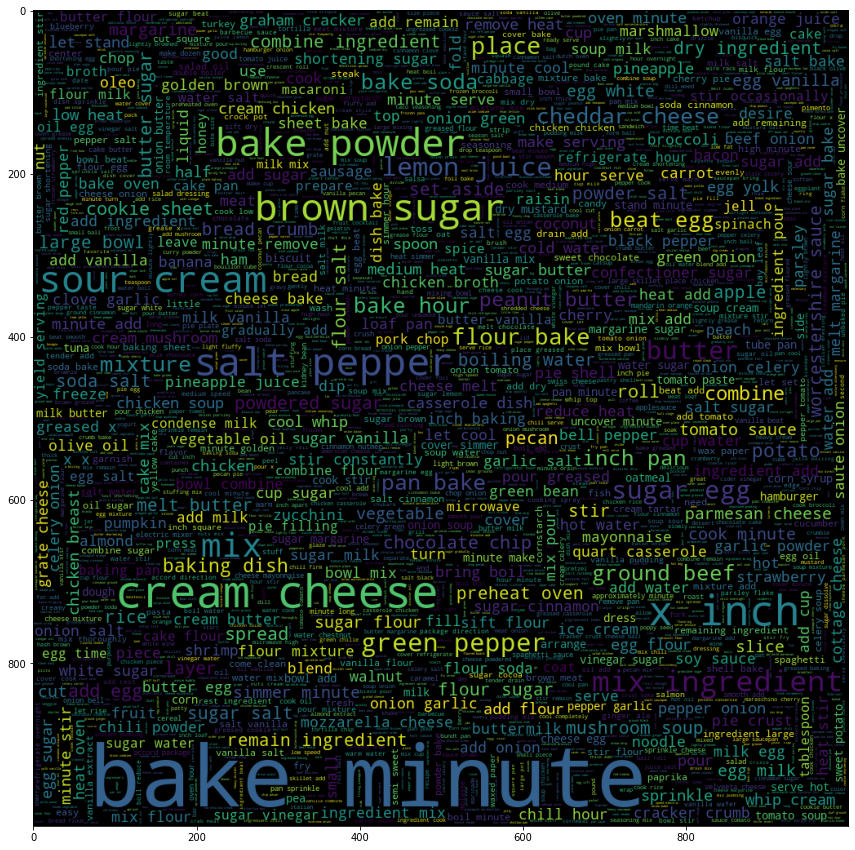

In [ ]:
st=""
for i in k:
  for j in i:
    st+=j+" "
mycloud = wc.WordCloud(max_words=4892,relative_scaling=1,width=1000,height=1000).generate(st)
plt.figure(figsize=(15,15))
plt.imshow(mycloud)

In [ ]:
sts=st.split()
distinct=set(sts)
print("number of words: {}\nnumber of unique words: {}".format(len(sts),len(distinct)))

number of words: 388395
number of unique words: 4892


In [ ]:
dtoken=[simple_preprocess(d, deacc= True, min_len=3) for d in docslemma]
phrases  = Phrases(dtoken, min_count = 2,threshold=9)
bigram=Phraser(phrases)
bdocs=[bigram[d] for d in dtoken]
bdc=[]
for i in bdocs:
  st=""
  for j in i:
    st+=j+" "
  bdc.append(st)
coll=[' '.join([d for w in l]) for l in bdocs]

In [ ]:
for i in bdc[:10]:
  print(i)

bake nut cookie brown sugar milk vanilla nuts butter bite_size shred rice biscuit heavy quart_saucepan mix brown sugar nuts evaporate_milk butter margarine stir medium_heat mixture bubble boil stir minute heat stir vanilla cereal mix teaspoon drop shape cluster wax_paper let_stand firm minute 
jewell ball chicken beef chicken_breast cream mushroom_soup sour_cream place chip beef baking_dish place chicken beef mix soup cream pour chicken bake uncover hour 
creamy corn frozen corn cream cheese butter garlic powder salt pepper slow_cooker combine ingredient cover cook low hour heat cheese melt stir serve yield_serving 
chicken funny chicken chicken gravy cream mushroom_soup shred cheese boil debone_chicken bite_size piece average_size square casserole_dish pour gravy cream mushroom_soup chicken level stuffing accord_instruction box moist stuffing chicken gravy level sprinkle shred cheese bake approximately minute golden bubbly 
reeses cup candy peanut_butter graham_cracker crumb butter po

In [ ]:
for i in bdocs[:10]:
  print(i)

['bake', 'nut', 'cookie', 'brown', 'sugar', 'milk', 'vanilla', 'nuts', 'butter', 'bite_size', 'shred', 'rice', 'biscuit', 'heavy', 'quart_saucepan', 'mix', 'brown', 'sugar', 'nuts', 'evaporate_milk', 'butter', 'margarine', 'stir', 'medium_heat', 'mixture', 'bubble', 'boil', 'stir', 'minute', 'heat', 'stir', 'vanilla', 'cereal', 'mix', 'teaspoon', 'drop', 'shape', 'cluster', 'wax_paper', 'let_stand', 'firm', 'minute']
['jewell', 'ball', 'chicken', 'beef', 'chicken_breast', 'cream', 'mushroom_soup', 'sour_cream', 'place', 'chip', 'beef', 'baking_dish', 'place', 'chicken', 'beef', 'mix', 'soup', 'cream', 'pour', 'chicken', 'bake', 'uncover', 'hour']
['creamy', 'corn', 'frozen', 'corn', 'cream', 'cheese', 'butter', 'garlic', 'powder', 'salt', 'pepper', 'slow_cooker', 'combine', 'ingredient', 'cover', 'cook', 'low', 'hour', 'heat', 'cheese', 'melt', 'stir', 'serve', 'yield_serving']
['chicken', 'funny', 'chicken', 'chicken', 'gravy', 'cream', 'mushroom_soup', 'shred', 'cheese', 'boil', 'deb

#BoW

In [ ]:
col_tokenized=bdocs
dictionary=corpora.Dictionary()
BoW=[dictionary.doc2bow(doc, allow_update=True) for doc in col_tokenized]
print(BoW[:20])
[print([(dictionary[id], count) for id, count in line]) for line in BoW[:20]]

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 2), (21, 1), (22, 1), (23, 2), (24, 1), (25, 1), (26, 1), (27, 1), (28, 3), (29, 2), (30, 1), (31, 2), (32, 1)], [(0, 1), (20, 1), (33, 1), (34, 1), (35, 3), (36, 3), (37, 1), (38, 1), (39, 2), (40, 1), (41, 1), (42, 1), (43, 2), (44, 1), (45, 1), (46, 1), (47, 1)], [(6, 1), (13, 1), (28, 1), (39, 1), (40, 1), (48, 2), (49, 1), (50, 1), (51, 2), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1)], [(0, 1), (2, 1), (3, 1), (19, 1), (27, 2), (36, 5), (39, 2), (42, 2), (44, 1), (48, 2), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 3), (75, 2), (76, 1), (77, 1), (78, 1), (79, 1), (80, 2)], [(6, 1), (19, 1), (21, 1), (49, 1), (56, 1), (58, 1), (77, 1), (81, 1), (82, 1), (83, 2), (84, 1), (85, 1), (86, 1), (87, 1)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

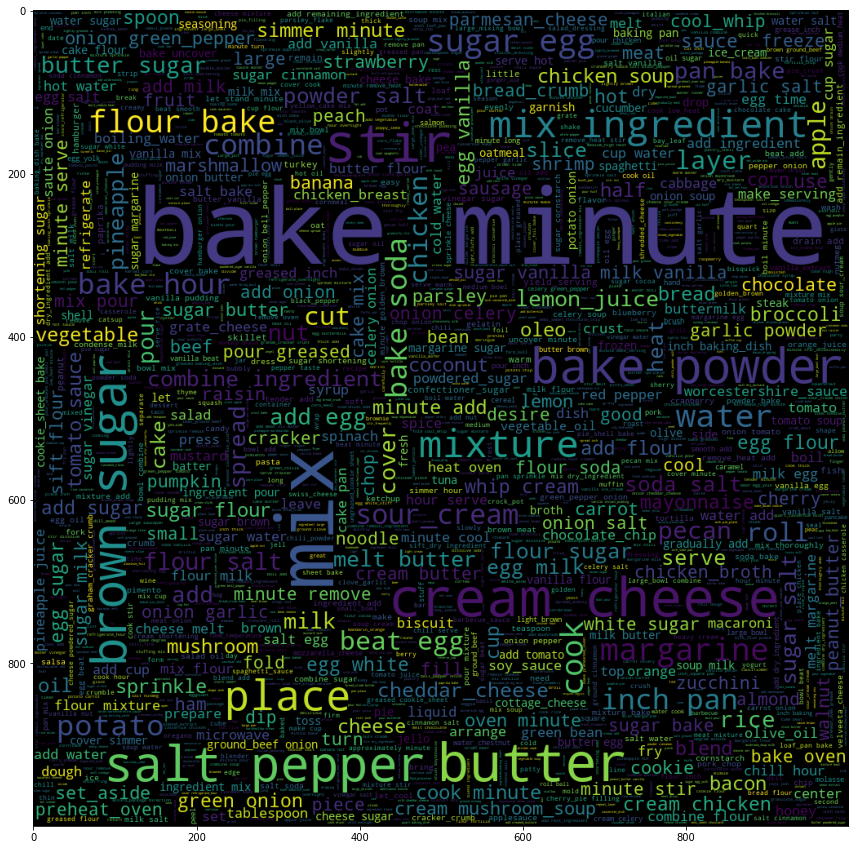

In [ ]:
st=""
for i in bdc:
  st+=i+" "
mycloud = wc.WordCloud(max_words=4892,relative_scaling=1,width=1000,height=1000).generate(st)
plt.figure(figsize=(15,15))
plt.imshow(mycloud)

In [ ]:
def printTopics(mdl,p=None):
	for k in range(mdl.k):
		print('Topic #{}'.format(k))
		if p is None:
			for word, prob in mdl.get_topic_words(topic_id=k,top_n=10):
				print(' ', word, prob, sep=' ')
		elif p==1:
			
			for word, prob in mdl.get_topic_words(topic_id=k,top_n=10,timepoint=0):
				print(' ', word, prob, sep=' ')
		else:
			for word, prob in mdl.get_topic_words(sub_topic_id=k,top_n=10):
				print(' ', word, prob, sep=' ')
			
			

def printCoherence(mdl):
	for preset in ('u_mass', 'c_uci', 'c_npmi', 'c_v'):
		coh = tp.coherence.Coherence(mdl, coherence=preset)
		average_coherence = coh.get_score()
		coherence_per_topic = [coh.get_score(topic_id=k) for k in range(mdl.k)]
	return average_coherence

def runModel(mdl,docs):
	for i,d in enumerate(docs):
		mdl.add_doc(d)
	mdl.burn_in = 100
	mdl.train(0)
	for i in range(0, 2000, 10):
		mdl.train(10)
    
	mdl.summary()
	mdl.save('test.lda.bin', True)


#Tests

##Attempt 1

In [ ]:
cv=[]
R=range(100,1000,150)
for i in R:
	mdl = tp.LDAModel(tw=tp.TermWeight.IDF, min_cf=3, rm_top=5, k=i,seed=7773) #,corpus=cp
	runModel(mdl,bdocs)
	cv.append(printCoherence(mdl))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.


<Basic Info>
| LDAModel (current version: 0.12.3)
| 10000 docs, 296409 words
| Total Vocabs: 6389, Used Vocabs: 3767
| Entropy of words: 6.29047
| Entropy of term-weighted words: 7.08801
| Removed Vocabs: add sugar bake minute mix
|
<Training Info>
| Iterations: 2000, Burn-in steps: 100
| Optimization Interval: 10
| Log-likelihood per word: -5.89437
|
<Initial Parameters>
| tw: TermWeight.IDF
| min_cf: 3 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 5 (the number of top words to be removed)
| k: 100 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (hyperparameter of Dirichlet distribution for document-topic, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 7773 (random seed)
| trained in version 0.12.3
|
<Parameters>
| alpha (Dirichlet prior on the per-document topic distribu

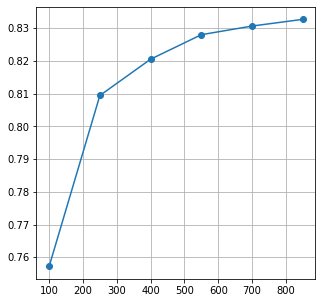

(0.8326990198142387, 850)


In [ ]:
plt.figure(figsize=(5,5))
plt.plot(list(R),cv,marker='o')
plt.grid(True)
plt.show()
print(max(zip(cv,list(R))))

##Attempt 2

In [ ]:
cv=[]
R=range(200,300,15)
for i in R:
	mdl = tp.LDAModel(tw=tp.TermWeight.IDF, min_cf=3, rm_top=5, k=i,seed=7773)
	runModel(mdl,bdocs)
	cv.append(printCoherence(mdl))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.


<Basic Info>
| LDAModel (current version: 0.12.3)
| 10000 docs, 296409 words
| Total Vocabs: 6389, Used Vocabs: 3767
| Entropy of words: 6.29047
| Entropy of term-weighted words: 7.08801
| Removed Vocabs: add sugar bake minute mix
|
<Training Info>
| Iterations: 2000, Burn-in steps: 100
| Optimization Interval: 10
| Log-likelihood per word: -5.69060
|
<Initial Parameters>
| tw: TermWeight.IDF
| min_cf: 3 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 5 (the number of top words to be removed)
| k: 200 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (hyperparameter of Dirichlet distribution for document-topic, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 7773 (random seed)
| trained in version 0.12.3
|
<Parameters>
| alpha (Dirichlet prior on the per-document topic distribu

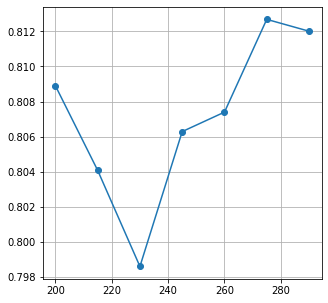

(0.8126910528052937, 275)


In [ ]:
plt.figure(figsize=(5,5))
plt.plot(list(R),cv,marker='o')
plt.grid(True)
plt.show()
print(max(zip(cv,list(R))))

##Attempt 3

In [ ]:
cv=[]
R=range(180,220,5)
for i in R:
	mdl = tp.LDAModel(tw=tp.TermWeight.IDF, min_cf=3, rm_top=5, k=i,seed=7773)
	runModel(mdl,bdocs)
	cv.append(printCoherence(mdl))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.


<Basic Info>
| LDAModel (current version: 0.12.3)
| 10000 docs, 296409 words
| Total Vocabs: 6389, Used Vocabs: 3767
| Entropy of words: 6.29047
| Entropy of term-weighted words: 7.08801
| Removed Vocabs: add sugar bake minute mix
|
<Training Info>
| Iterations: 2000, Burn-in steps: 100
| Optimization Interval: 10
| Log-likelihood per word: -5.71692
|
<Initial Parameters>
| tw: TermWeight.IDF
| min_cf: 3 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 5 (the number of top words to be removed)
| k: 180 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (hyperparameter of Dirichlet distribution for document-topic, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 7773 (random seed)
| trained in version 0.12.3
|
<Parameters>
| alpha (Dirichlet prior on the per-document topic distribu

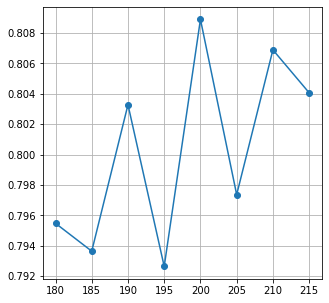

(0.8089038643985986, 200)


In [ ]:
plt.figure(figsize=(5,5))
plt.plot(list(R),cv,marker='o')
plt.grid(True)
plt.show()
print(max(zip(cv,list(R))))

##Results

In [ ]:
mdl = tp.LDAModel(tw=tp.TermWeight.IDF, min_cf=3, rm_top=5, k=200,seed=7773)
runModel(mdl,bdocs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.


<Basic Info>
| LDAModel (current version: 0.12.3)
| 10000 docs, 296409 words
| Total Vocabs: 6389, Used Vocabs: 3767
| Entropy of words: 6.29047
| Entropy of term-weighted words: 7.08801
| Removed Vocabs: add sugar bake minute mix
|
<Training Info>
| Iterations: 2000, Burn-in steps: 100
| Optimization Interval: 10
| Log-likelihood per word: -5.69060
|
<Initial Parameters>
| tw: TermWeight.IDF
| min_cf: 3 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 5 (the number of top words to be removed)
| k: 200 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (hyperparameter of Dirichlet distribution for document-topic, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 7773 (random seed)
| trained in version 0.12.3
|
<Parameters>
| alpha (Dirichlet prior on the per-document topic distribu

##An Idea

In [ ]:
cv=[]
R=range(2,100,5)
for i in R:
	mdl = tp.LDAModel(tw=tp.TermWeight.IDF, min_cf=3, rm_top=5, k=i,seed=7773)
	runModel(mdl,bdocs)
	cv.append(printCoherence(mdl)/i)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.


<Basic Info>
| LDAModel (current version: 0.12.3)
| 10000 docs, 296409 words
| Total Vocabs: 6389, Used Vocabs: 3767
| Entropy of words: 6.29047
| Entropy of term-weighted words: 7.08801
| Removed Vocabs: add sugar bake minute mix
|
<Training Info>
| Iterations: 2000, Burn-in steps: 100
| Optimization Interval: 10
| Log-likelihood per word: -6.86153
|
<Initial Parameters>
| tw: TermWeight.IDF
| min_cf: 3 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 5 (the number of top words to be removed)
| k: 2 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (hyperparameter of Dirichlet distribution for document-topic, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 7773 (random seed)
| trained in version 0.12.3
|
<Parameters>
| alpha (Dirichlet prior on the per-document topic distributi

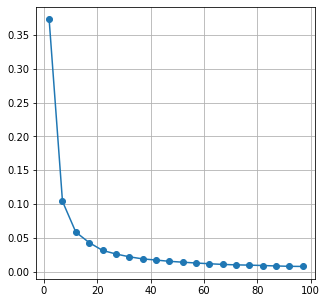

(0.37297867983579636, 2)


In [ ]:
plt.figure(figsize=(5,5))
plt.plot(list(R),cv,marker='o')
plt.grid(True)
plt.show()
print(max(zip(cv,list(R))))

In [ ]:
cv=[]
R=range(70,90,1)
for i in R:
	mdl = tp.LDAModel(tw=tp.TermWeight.IDF, min_cf=3, rm_top=5, k=i,seed=7773)
	runModel(mdl,bdocs)
	cv.append(printCoherence(mdl))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.


<Basic Info>
| LDAModel (current version: 0.12.3)
| 10000 docs, 296409 words
| Total Vocabs: 6389, Used Vocabs: 3767
| Entropy of words: 6.29047
| Entropy of term-weighted words: 7.08801
| Removed Vocabs: add sugar bake minute mix
|
<Training Info>
| Iterations: 2000, Burn-in steps: 100
| Optimization Interval: 10
| Log-likelihood per word: -6.02451
|
<Initial Parameters>
| tw: TermWeight.IDF
| min_cf: 3 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 5 (the number of top words to be removed)
| k: 70 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (hyperparameter of Dirichlet distribution for document-topic, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 7773 (random seed)
| trained in version 0.12.3
|
<Parameters>
| alpha (Dirichlet prior on the per-document topic distribut

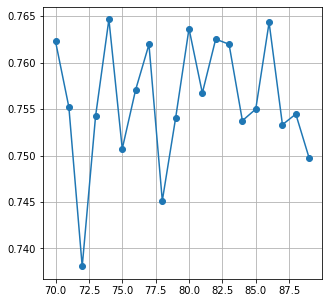

(0.7646509160665242, 74)


In [ ]:
plt.figure(figsize=(5,5))
plt.plot(list(R),cv,marker='o')
plt.grid(True)
plt.show()
print(max(zip(cv,list(R))))

##True Result

In [ ]:
cv=[]
R=range(900,1000,99)
for i in R:
	mdl = tp.LDAModel(tw=tp.TermWeight.IDF, min_cf=3, rm_top=5, k=i,seed=7773)
	runModel(mdl,bdocs)
	cv.append(printCoherence(mdl))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.


<Basic Info>
| LDAModel (current version: 0.12.3)
| 10000 docs, 296409 words
| Total Vocabs: 6389, Used Vocabs: 3767
| Entropy of words: 6.29047
| Entropy of term-weighted words: 7.08801
| Removed Vocabs: add sugar bake minute mix
|
<Training Info>
| Iterations: 2000, Burn-in steps: 100
| Optimization Interval: 10
| Log-likelihood per word: -5.35529
|
<Initial Parameters>
| tw: TermWeight.IDF
| min_cf: 3 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 5 (the number of top words to be removed)
| k: 900 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (hyperparameter of Dirichlet distribution for document-topic, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 7773 (random seed)
| trained in version 0.12.3
|
<Parameters>
| alpha (Dirichlet prior on the per-document topic distribu

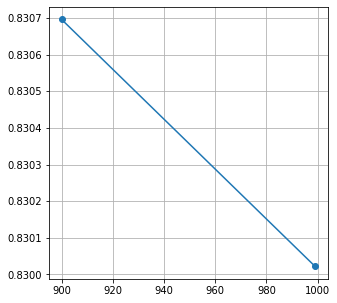

(0.830696350700326, 900)


In [ ]:
plt.figure(figsize=(5,5))
plt.plot(list(R),cv,marker='o')
plt.grid(True)
plt.show()
print(max(zip(cv,list(R))))

In [ ]:
cv=[]
R=range(800,1000,49)
for i in R:
	mdl = tp.LDAModel(tw=tp.TermWeight.IDF, min_cf=3, rm_top=5, k=i,seed=7773)
	runModel(mdl,bdocs)
	cv.append(printCoherence(mdl))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.


Streaming output truncated to the last 5000 lines.
| #544 (71) : salsa cilantro fresh_cilantro lime_juice papaya
| #545 (279) : low_speed high_speed beat scrape_bowl mixer
| #546 (70) : wild_rice rice uncle_ben mushroom long_grain
| #547 (653) : potato mashed_potato mash paprika shepherd_pie
| #548 (60) : hot cold dab serve throw
| #549 (23) : glaze min careful thermometer rest
| #550 (5) : peppercorn pink spoon fresh vegetable
| #551 (17) : lard spatula countertop mess kitchen
| #552 (145) : shell pasta italian_seasoning hollow stuff
| #553 (609) : bean black pinto_bean water tender
| #554 (19) : bagel italian_seasoning approximately_people bubbly_approximately slotted_spoon
| #555 (65) : fruit_cocktail hominy yellow_hominy whip_top brown
| #556 (104) : okra gumbo gumbo_file file bacon
| #557 (360) : blueberry berry blueberry_muffin lemon_rind sour_cream
| #558 (42) : tortilla bakon ice_cream deep_fry end
| #559 (30) : fiesta tortilla recipe_secret chile herb
| #560 (25) : coriander_s

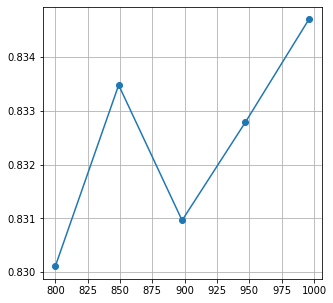

(0.8347024780649486, 996)


In [ ]:
plt.figure(figsize=(5,5))
plt.plot(list(R),cv,marker='o')
plt.grid(True)
plt.show()
print(max(zip(cv,list(R))))

#Model

In [ ]:
myModel = LdaModel(corpus = BoW,num_topics= 74, random_state= 27644437, id2word = dictionary, alpha = 'auto',per_word_topics = True,passes = 100)
for t in myModel.show_topics():
  print(t)

(2, '0.139*"basil" + 0.072*"low_fat" + 0.052*"paste" + 0.041*"prepared" + 0.034*"ahead" + 0.030*"calorie" + 0.029*"repeat_layer" + 0.022*"separately" + 0.020*"cooked_rice" + 0.020*"min"')
(20, '0.122*"soy_sauce" + 0.116*"shrimp" + 0.100*"fry" + 0.048*"stir" + 0.048*"add" + 0.038*"garlic" + 0.032*"pear" + 0.030*"heat" + 0.022*"grate" + 0.021*"minute"')
(29, '0.140*"orange" + 0.085*"cranberry" + 0.052*"add" + 0.041*"jello" + 0.040*"salad" + 0.037*"fruit" + 0.032*"pineapple" + 0.032*"sugar" + 0.030*"mix" + 0.026*"mandarin_orange"')
(51, '0.372*"broccoli" + 0.082*"turkey" + 0.061*"mayonnaise" + 0.042*"cook" + 0.040*"great" + 0.028*"chive" + 0.027*"onion" + 0.026*"hash_brown" + 0.023*"cooked" + 0.016*"combine"')
(59, '0.163*"tortilla" + 0.061*"yield" + 0.061*"green_chilie" + 0.045*"avocado" + 0.045*"wedge" + 0.044*"serve_immediately" + 0.037*"diced" + 0.034*"chilie" + 0.027*"quart_saucepan" + 0.024*"medium_size"')
(69, '0.159*"pan" + 0.154*"cake" + 0.113*"mix" + 0.074*"bake" + 0.069*"minute

In [ ]:
# docs topics
for i,d in enumerate(BoW): # collection and bagofwords must be synchronized
  print(bdocs[i],':',myModel.get_document_topics(d,minimum_probability=0.3)) #threshold

Streaming output truncated to the last 5000 lines.
['pickled', 'pepper', 'long', 'red', 'pickle', 'salt', 'garlic', 'horseradish', 'vinegar', 'water', 'sugar', 'wash', 'drain', 'pepper', 'cut', 'small', 'slit', 'pepper', 'dissolve', 'salt', 'gallon', 'water', 'pour', 'pepper', 'let_stand', 'hour', 'cool', 'place', 'drain_rinse', 'drain', 'thoroughly', 'combine', 'remain_ingredient', 'simmer', 'minute', 'remove', 'garlic', 'pack', 'pepper', 'jar', 'leave', 'inch_headspace', 'bring', 'liquid', 'boil', 'fill', 'jar', 'inch', 'boiling', 'liquid', 'remove', 'air_bubble', 'adjust_lid', 'process', 'minute', 'boiling_water', 'bath', 'yield_pint'] : [(41, 0.31408465)]
['banana', 'nut', 'salad', 'jello', 'salt', 'boiling_water', 'cold_water', 'lemon_juice', 'banana', 'celery', 'pecan', 'dissolve_gelatin', 'salt', 'boiling_water', 'add', 'cold_water', 'lemon_juice', 'chill', 'thickened', 'fold', 'banana', 'slice', 'celery', 'nuts', 'pour', 'cup', 'mold_chill', 'firm_unmold', 'serve', 'crisp', 'le

In [ ]:
tops=[]
for k in range(2):
    t=[]
    for wt in myModel.show_topic(k):
      t.append(wt[0])
    tops.append(t)
for t in tops:
  topic_coher=CoherenceModel(topics=[t], texts= bdocs, dictionary=dictionary, coherence='c_v')
  print('topic:',t)
  print('C_v:%.3f'%(topic_coher.get_coherence()))
print("All:")
topic_coher=CoherenceModel(topics=tops, texts= bdocs, dictionary=dictionary, coherence='c_v')
print('C_v:%.3f'%(topic_coher.get_coherence()))
# top topics
print('Topics with the highest coherence score the coherence for each topic.')
myModel.top_topics(corpus=BoW,dictionary=dictionary,coherence='c_v',texts=bdocs,topn=5)

topic: ['cut', 'slice', 'piece', 'inch', 'place', 'thin', 'strip', 'sprinkle', 'pat', 'spread']
C_v:0.283
topic: ['chocolate', 'chocolate_chip', 'nuts', 'nut', 'melt', 'vanilla', 'semi_sweet', 'date', 'brownie', 'stir']
C_v:0.430
All:
C_v:0.545
Topics with the highest coherence score the coherence for each topic.


[([(0.17042463, 'nutmeg'),
   (0.16434722, 'pumpkin'),
   (0.11930265, 'ginger'),
   (0.096924566, 'spice'),
   (0.088713296, 'clove')],
  0.8902158008181725),
 ([(0.09694907, 'bake'),
   (0.09237595, 'flour'),
   (0.090431206, 'soda'),
   (0.08236529, 'shortening'),
   (0.076600224, 'sugar')],
  0.8353846920971092),
 ([(0.11258125, 'sauce'),
   (0.10778155, 'noodle'),
   (0.09658167, 'parmesan_cheese'),
   (0.048389662, 'mozzarella_cheese'),
   (0.041066736, 'pizza')],
  0.8312376502199783),
 ([(0.12582953, 'tomato'),
   (0.09661841, 'pepper'),
   (0.08047273, 'garlic'),
   (0.07919119, 'salt'),
   (0.056163758, 'onion')],
  0.8062238662346536),
 ([(0.23644991, 'juice'),
   (0.058053944, 'orange_juice'),
   (0.055119216, 'serve'),
   (0.03899566, 'pineapple'),
   (0.03781017, 'ginger_ale')],
  0.8006903527818288),
 ([(0.23818964, 'pie'),
   (0.08914498, 'crust'),
   (0.08625617, 'pie_shell'),
   (0.06338719, 'shell'),
   (0.061878018, 'pour')],
  0.7969499764981306),
 ([(0.07817403, '

In [ ]:
tops_frequency=[0]*74
x=0
for d in BoW:
  aux=myModel.get_document_topics(d,minimum_probability=0.5)
  if aux!=[]:
    tops_frequency[aux[0][0]]+=1
print(tops_frequency)
  # print(myModel.get_document_topics(d,minimum_probability=0.3)) #threshold
for i in range(74):
  aux1=[tops_frequency[i],i]
  tops_frequency[i]=aux1
tops_frequency.sort()
tops_frequency.reverse()
print(tops_frequency)
aux2=[0]*10
for i in range(10):
  aux2[i]=tops_frequency[i][1]
print(aux2)

[0, 3, 0, 1, 2, 0, 3, 8, 0, 0, 0, 0, 0, 0, 5, 1, 3, 0, 0, 24, 1, 12, 2, 2, 0, 16, 0, 38, 0, 8, 6, 34, 1, 0, 20, 0, 0, 25, 0, 0, 4, 0, 0, 0, 18, 0, 0, 17, 0, 0, 0, 0, 5, 0, 0, 0, 84, 0, 1, 0, 0, 8, 17, 1, 0, 0, 0, 7, 3, 4, 0, 0, 0, 0]
[[84, 56], [38, 27], [34, 31], [25, 37], [24, 19], [20, 34], [18, 44], [17, 62], [17, 47], [16, 25], [12, 21], [8, 61], [8, 29], [8, 7], [7, 67], [6, 30], [5, 52], [5, 14], [4, 69], [4, 40], [3, 68], [3, 16], [3, 6], [3, 1], [2, 23], [2, 22], [2, 4], [1, 63], [1, 58], [1, 32], [1, 20], [1, 15], [1, 3], [0, 73], [0, 72], [0, 71], [0, 70], [0, 66], [0, 65], [0, 64], [0, 60], [0, 59], [0, 57], [0, 55], [0, 54], [0, 53], [0, 51], [0, 50], [0, 49], [0, 48], [0, 46], [0, 45], [0, 43], [0, 42], [0, 41], [0, 39], [0, 38], [0, 36], [0, 35], [0, 33], [0, 28], [0, 26], [0, 24], [0, 18], [0, 17], [0, 13], [0, 12], [0, 11], [0, 10], [0, 9], [0, 8], [0, 5], [0, 2], [0, 0]]
[56, 27, 31, 37, 19, 34, 44, 62, 47, 25]


In [ ]:
for i in aux2:
  print(myModel.show_topics(num_topics=74)[i])

(56, '0.078*"bake" + 0.060*"egg" + 0.056*"raisin" + 0.052*"flour" + 0.048*"sugar" + 0.045*"soda" + 0.038*"oil" + 0.037*"add" + 0.035*"salt" + 0.031*"cinnamon"')
(27, '0.145*"sugar" + 0.100*"brown" + 0.074*"bake" + 0.062*"butter" + 0.060*"flour" + 0.058*"vanilla" + 0.055*"egg" + 0.048*"minute" + 0.040*"salt" + 0.039*"soda"')
(31, '0.090*"onion" + 0.077*"meat" + 0.069*"tomato" + 0.058*"brown" + 0.058*"add" + 0.051*"beef" + 0.051*"sauce" + 0.043*"ground_beef" + 0.042*"salt" + 0.028*"pepper"')
(37, '0.115*"beat" + 0.114*"add" + 0.114*"egg" + 0.109*"sugar" + 0.074*"vanilla" + 0.038*"flour" + 0.029*"cream" + 0.023*"egg_yolk" + 0.022*"time" + 0.022*"salt"')
(19, '0.076*"flour" + 0.062*"dough" + 0.046*"roll" + 0.034*"yeast" + 0.033*"salt" + 0.032*"minute" + 0.030*"place" + 0.024*"cut" + 0.022*"warm" + 0.018*"bowl"')
(34, '0.145*"vinegar" + 0.112*"sugar" + 0.060*"cabbage" + 0.055*"salt" + 0.039*"mustard" + 0.036*"pour" + 0.034*"onion" + 0.027*"mix" + 0.026*"pepper" + 0.022*"sweet"')
(44, '0.260

In [ ]:
myModel.top_topics(corpus=BoW,dictionary=dictionary,coherence='c_v',texts=bdocs,topn=10)[:10]

[([(0.0898172, 'onion'),
   (0.07662229, 'meat'),
   (0.06860511, 'tomato'),
   (0.0579076, 'brown'),
   (0.057579976, 'add'),
   (0.051230967, 'beef'),
   (0.050728496, 'sauce'),
   (0.042979322, 'ground_beef'),
   (0.041962393, 'salt'),
   (0.027572071, 'pepper')],
  0.7436709964664645),
 ([(0.07817403, 'bake'),
   (0.06002794, 'egg'),
   (0.056133978, 'raisin'),
   (0.052081037, 'flour'),
   (0.04828619, 'sugar'),
   (0.045085, 'soda'),
   (0.037762843, 'oil'),
   (0.037265196, 'add'),
   (0.034720704, 'salt'),
   (0.03133376, 'cinnamon')],
  0.7158553612928035),
 ([(0.08935122, 'crumb'),
   (0.06666175, 'pan'),
   (0.05281593, 'press'),
   (0.05265727, 'graham_cracker'),
   (0.04567088, 'spread'),
   (0.045371026, 'inch'),
   (0.033917032, 'mixture'),
   (0.0317059, 'crust'),
   (0.029836515, 'sprinkle'),
   (0.028520154, 'evenly')],
  0.7142888476124544),
 ([(0.12582953, 'tomato'),
   (0.09661841, 'pepper'),
   (0.08047273, 'garlic'),
   (0.07919119, 'salt'),
   (0.056163758, 'oni

In [ ]:
# aux2=[56, 27, 31, 37, 19, 34, 44, 62, 47, 25]
aux2+=[33,16,46,58,40]
for i in aux2:
  print(myModel.show_topics(num_topics=74)[i])

(56, '0.078*"bake" + 0.060*"egg" + 0.056*"raisin" + 0.052*"flour" + 0.048*"sugar" + 0.045*"soda" + 0.038*"oil" + 0.037*"add" + 0.035*"salt" + 0.031*"cinnamon"')
(27, '0.145*"sugar" + 0.100*"brown" + 0.074*"bake" + 0.062*"butter" + 0.060*"flour" + 0.058*"vanilla" + 0.055*"egg" + 0.048*"minute" + 0.040*"salt" + 0.039*"soda"')
(31, '0.090*"onion" + 0.077*"meat" + 0.069*"tomato" + 0.058*"brown" + 0.058*"add" + 0.051*"beef" + 0.051*"sauce" + 0.043*"ground_beef" + 0.042*"salt" + 0.028*"pepper"')
(37, '0.115*"beat" + 0.114*"add" + 0.114*"egg" + 0.109*"sugar" + 0.074*"vanilla" + 0.038*"flour" + 0.029*"cream" + 0.023*"egg_yolk" + 0.022*"time" + 0.022*"salt"')
(19, '0.076*"flour" + 0.062*"dough" + 0.046*"roll" + 0.034*"yeast" + 0.033*"salt" + 0.032*"minute" + 0.030*"place" + 0.024*"cut" + 0.022*"warm" + 0.018*"bowl"')
(34, '0.145*"vinegar" + 0.112*"sugar" + 0.060*"cabbage" + 0.055*"salt" + 0.039*"mustard" + 0.036*"pour" + 0.034*"onion" + 0.027*"mix" + 0.026*"pepper" + 0.022*"sweet"')
(44, '0.260

#Labeling

In [ ]:
ddd=[]
for j in aux2:
  ddd2=[]
  for i,d in enumerate(BoW):
    if len(ddd)<10:
      aux=myModel.get_document_topics(d,minimum_probability=0.5)
    else:
      aux=myModel.get_document_topics(d,minimum_probability=0.3)
    if aux!=[]:
      if aux[0][0]==j:
        ddd2.append(i)
        # print(aux[0],':',i,bdocs[i])
  ddd.append(ddd2)

In [ ]:
for i in ddd:
  print(len(i),end=" ")

83 38 33 25 24 20 18 17 17 16 27 56 2 37 61 

In [ ]:
receitas.head()

Unnamed: 0                  title  \
0           0    No-Bake Nut Cookies   
1           1  Jewell Ball'S Chicken   
2           2            Creamy Corn   
3           3          Chicken Funny   
4           4   Reeses Cups(Candy)     

                                         ingredients  \
0  ["1 c. firmly packed brown sugar", "1/2 c. eva...   
1  ["1 small jar chipped beef, cut up", "4 boned ...   
2  ["2 (16 oz.) pkg. frozen corn", "1 (8 oz.) pkg...   
3  ["1 large whole chicken", "2 (10 1/2 oz.) cans...   
4  ["1 c. peanut butter", "3/4 c. graham cracker ...   

                                          directions  \
0  ["In a heavy 2-quart saucepan, mix brown sugar...   
1  ["Place chipped beef on bottom of baking dish....   
2  ["In a slow cooker, combine all ingredients. C...   
3  ["Boil and debone chicken.", "Put bite size pi...   
4  ["Combine first four ingredients and press in ...   

                                              link    source  \
0   www.cookbooks.com/Recipe-Details.aspx?id=44874  Gathered   
1  www.cookbooks.com/Recipe-Details.aspx?id=699419  Gathered   
2   www.cookbooks.com/Recipe-Details.aspx?id=10570  Gathered   
3  www.cookbooks.com/Recipe-Details.aspx?id=897570  Gathered   
4  www.cookbooks.com/Recipe-Details.aspx?id=659239  Gathered   

                                                 NER  
0  ["brown sugar", "milk", "vanilla", "nuts", "bu...  
1  ["beef", "chicken breasts", "cream of mushroom...  
2  ["frozen corn", "cream cheese", "butter", "gar...  
3  ["chicken", "chicken gravy", "cream of mushroo...  
4  ["peanut butter", "graham cracker crumbs", "bu...

##seeing all the recipes per topic

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 1)

lables=[]

###topic 0

In [ ]:
print(myModel.show_topics(num_topics=74)[aux2[0]])

(56, '0.078*"bake" + 0.060*"egg" + 0.056*"raisin" + 0.052*"flour" + 0.048*"sugar" + 0.045*"soda" + 0.038*"oil" + 0.037*"add" + 0.035*"salt" + 0.031*"cinnamon"')


In [ ]:
receitasaux=receitas.iloc[ddd[0]]
receitasaux.head(82)

Unnamed: 0                                   title  \
19    19          Eggless Milkless Applesauce Cake         
213   213         Carrot Bread                             
266   266         Pumpkin Bread                            
296   296         Applesauce Cake                          
363   363         Carrot-Pineapple Bread                   
586   586         Raisin-Walnut Bread                      
684   684         Zucchini Bread                           
694   694         Pumpkin Bread                            
763   763         Zucchini Bread                           
870   870         Zucchini Muffins                         
940   940         Strawberry Bread                         
960   960         Strawberry Bread                         
1059  1059        Pumpkin Bread                            
1149  1149        Raisin Bread                             
1403  1403        Carrot Cake                              
1422  1422        Easy Bran Muffins                        
1533  1533        Zucchini Fruit Bread(Sugar-Free)         
1547  1547        Pumpkin Bread                            
1949  1949        Banana Nut Bread                         
2032  2032        Zucchini Bread                           
2815  2815        Strawberry Bread                         
2913  2913        Zucchini Bread                           
3038  3038        Banana Nut Bread                         
3143  3143        Zucchini Bread                           
3177  3177        Zucchini Pineapple Bread                 
3349  3349        Quick Zucchini Cake                      
3351  3351        Moist Oatmeal Cookies                    
3366  3366        Spicy Pineapple Zucchini Bread           
3375  3375        Pumpkin Bread                            
3509  3509        Pumpkin Pie Cake                         
3788  3788        Mom'S Date Nut Bread                     
3946  3946        Pumpkin Bread                            
3964  3964        Spicy Pumpkin Bread                      
4047  4047        Zucchini Bread                           
4225  4225        Zucchini Nut Bread                       
4315  4315        Pumpkin Muffins                          
4344  4344        Pumpkin Bread                            
4414  4414        Nut Bread                                
4506  4506        Hummingbird Cake                         
4666  4666        Pumpkin Bread                            
4697  4697        Fresh Apple Cake                         
4723  4723        Fresh Pear Cake                          
4913  4913        Zucchini Bread                           
4941  4941        Carrot Cake #1                           
5040  5040        Zucchini Muffins                         
5116  5116        Zucchini Bread                           
5400  5400        Sugar-Free - Applesauce Raisin Muffins   
5409  5409        Zucchini Squash Cake                     
5518  5518        Pumpkin Bread                            
5569  5569        Morning Glory Muffins                    
5633  5633        Pumpkin Bread                            
5765  5765        Zucchini Bread                           
5946  5946        Zucchini Bread                           
6035  6035        Strawberry Bread                         
6276  6276        Cranberry Nut Bread                      
6488  6488        Oatmeal Strawberry Bread                 
6496  6496        Zucchini Squash Bread                    
6568  6568        Banana Nut Bread With Raisins            
6637  6637        Pumpkin Bars                             
6788  6788        Strawberry Bread                         
7368  7368        Pear Cake                                
7386  7386        Chocolate Chip Pumpkin Cake              
7390  7390        Apple Bread                              
7435  7435        Squash Bread                             
7632  7632        Fresh Apple Cake                         
7779  7779        Zucchini Bread              

In [ ]:
lables.append("Sweet breads: Breads, Cakes and Muffins")

###topic 1

In [ ]:
print(myModel.show_topics(num_topics=74)[aux2[1]])

(27, '0.145*"sugar" + 0.100*"brown" + 0.074*"bake" + 0.062*"butter" + 0.060*"flour" + 0.058*"vanilla" + 0.055*"egg" + 0.048*"minute" + 0.040*"salt" + 0.039*"soda"')


In [ ]:
receitasaux=receitas.iloc[ddd[1]]
receitasaux.head(82)

Unnamed: 0                               title  \
284   284         Fruitcake Cookies                    
463   463         Butternut Cookies                    
802   802         California Cookies                   
1082  1082        Blonde Brownies                      
1136  1136        Soft Date Cookies                    
2124  2124        Applesauce Cookies                   
2338  2338        Nut Cookies                          
2586  2586        Blonde Brownies                      
2978  2978        Potato Chip Cookies                  
2998  2998        Salted Peanut Cookies                
3628  3628        Cookies                              
4132  4132        Brownies                             
4314  4314        California Butter Balls              
4766  4766        Chocolate Chip Cookies               
4770  4770        Macaroons                            
4831  4831        Monster Cookies                      
4852  4852        Peewee Cookies                       
5562  5562        Fudge Brownies                       
5604  5604        Elephant Cookies                     
5743  5743        Old Fashioned Sugar Cookies          
6109  6109        Sugar Cookies                        
6155  6155        Peanut Butter Cookies                
6158  6158        Cranberry Cookies                    
6188  6188        Mrs. Jeffer'S Refrigerator Cookies   
6236  6236        Old Fashioned Sugar Pie              
6459  6459        Bean Pie                             
6517  6517        Chocolate Chip Cookies               
7005  7005        Pineapple Cookies                    
7174  7174        Rocks                                
7264  7264        Chocolate Chip Cookies               
7706  7706        Sugar Cookies                        
8435  8435        Good Christmas Cookies               
8849  8849        Soft Sugar Cookies                   
9605  9605        Fudge Bars                           
9728  9728        Pecan Pie                            
9775  9775        Big Cookie                           
9815  9815        Moist Drop Cookie                    
9986  9986        Chocolate Chip Cookies               

                                                                                                                                                                                                                                                                                                                                       ingredients  \
284   ["1 c. light brown sugar", "3 eggs", "3 c. self rising flour", "1 tsp. cinnamon", "1/2 c. milk", "2 lbs candied fruit or 6 slices of candied pineapple and 2 cups of candied cherries", "3 to 4 c. of pecans"]                                                                                                                                 
463   ["2 c. butter", "1 c. sugar", "4 tsp. vanilla", "4 c. flour", "1 tsp. salt", "4 c. finely chopped walnuts", "confectioners sugar"]                                                                                                                                                                                                             
802   ["1/2 cup butter/margarine", "1 cup flour", "2 Tbsp. sugar", "1-1/2 cups brown sugar", "1/2 cup coconut", "1-1/2 tsp. salt", "1/4 tsp. baking soda", "1 cup chopped pecans", "2 eggs", "2 Tbsp. flour", "1 Tbsp. vanilla", "1-1/2 cups powdered sugar", "2 Tbsp. lemon juice", "A few drops green food coloring"]                              
1082  ["2 c. flour", "1/4 tsp. soda", "1 tsp. baking powder", "1 tsp. salt", "2 c. brown sugar", "2/3 c. butter", "2 eggs", "2 tsp. vanilla", "1 c. chocolate chips", "1/3 c. chopped nuts"]                                                                                                                                                         
1136  ["1 pkg dates cut up", "2 tsp soda", "2 c. sugar", "2 Tbsp butter", "2 eggs", "2 tsp vanilla", "4 c. flou

In [ ]:
lables.append("Hard dough: Cookies, Pies and Brownies")

###topic 2

In [ ]:
print(myModel.show_topics(num_topics=74)[aux2[2]])

(31, '0.090*"onion" + 0.077*"meat" + 0.069*"tomato" + 0.058*"brown" + 0.058*"add" + 0.051*"beef" + 0.051*"sauce" + 0.043*"ground_beef" + 0.042*"salt" + 0.028*"pepper"')


In [ ]:
receitasaux=receitas.iloc[ddd[2]]
receitasaux.head(82)

Unnamed: 0                            title  \
793   793         Taco Beans                        
877   877         Chunky Cheddar Chili Beans        
945   945         Carrie'S Cabbage Soup             
1525  1525        Spaghetti Sauce                   
1552  1552        Lasagna                           
1950  1950        Spaghetti Sauce                   
2159  2159        Skillet Macaroni And Beef         
2213  2213        Memphis Spicy Baked Beans         
2271  2271        Society Spaghetti                 
2296  2296        Microwave Spaghetti Sauce         
2566  2566        Coney Island Sauce                
2724  2724        Angie Weis' Prize Winning Chili   
2745  2745        Chilli                            
2788  2788        Rice And Beef Porcupines          
3012  3012        Sloppy Joes                       
3398  3398        Slomgolian                        
3561  3561        Chili                             
3849  3849        Beans For Tacos                   
4287  4287        Corned Beef Barbecue              
4318  4318        Sloppy Joes                       
4495  4495        Can Opener Stew                   
5434  5434        Spaghetti Sauce                   
5704  5704        Pepper Sauce                      
5755  5755        Skillet Macaroni And Beef         
6914  6914        Spaghetti Sauce                   
6980  6980        Barbecue Beef Sandwiches          
7012  7012        Chili                             
7413  7413        Ketchup Swiss Steak               
7960  7960        Sloppy Joes                       
9052  9052        Barbecue                          
9056  9056        Best Ever Barbecue Sauce          
9288  9288        Spaghetti                         
9342  9342        Barbecued Beans                   

                                                                                                                                                                                                                                                                                                                                                                                                                                                            ingredients  \
793   ["2 lb. pinto beans", "2 lb. ground meat", "2 cans taco sauce", "1 can roasted green chilies", "1 (No. 2) can tomatoes", "1 tsp. chili powder", "1/2 c. chopped bell pepper", "1/2 tsp. cumin", "2 large onions", "4 garlic buds"]                                                                                                                                                                                                                                  
877   ["1 lb. ground beef", "1 can kidney beans, rinsed and drained", "1/2 c. chopped onions", "1 lb. can whole tomatoes, chopped", "6 oz. can tomato paste", "1 Tbsp. chili powder", "2 tsp. sugar", "1 tsp. salt", "1/4 tsp. pepper", "cubed Cheddar cheese"]                                                                                                                                                                                                           
945   ["6 c. shredded green cabbage", "1 c. chopped onion", "2 c. diced celery", "1/2 c. diced green pepper", "1/2 tsp. thyme", "1/4 tsp. marjoram", "1 Tbsp. anisette", "6 peeled ripe red tomatoes", "2 pkg. dry onion soup mix", "2 cans beef bouillon", "water", "1/4 tsp. tarragon", "2 Tbsp. granulated sugar", "8 oz. tomato sauce", "1 lb. ground beef, browned (optional)", "1 lb. sausage (link, Polish, Italian, kielbasi or ground, browned or precooked)"]   
1525  ["3 cans Contadina tomato paste", "medium onion, sliced", "salt", "9 cans water", "heaping Tbsp. butter", "mushrooms (optional)", "cooked ground beef"]                                                                                                                                                                                                                  

In [ ]:
lables.append("Meat lunch: Beans, Steak, Pasta and Sauces")

###topic 3

In [ ]:
print(myModel.show_topics(num_topics=74)[aux2[3]])

(37, '0.115*"beat" + 0.114*"add" + 0.114*"egg" + 0.109*"sugar" + 0.074*"vanilla" + 0.038*"flour" + 0.029*"cream" + 0.023*"egg_yolk" + 0.022*"time" + 0.022*"salt"')


In [ ]:
receitasaux=receitas.iloc[ddd[3]]
receitasaux.head(82)

Unnamed: 0                           title  \
275   275         Angel Food Cake                  
446   446         Sour Cream Pound Cake            
656   656         Bourbon Pound Cake               
791   791         Texas Prize Cake                 
1345  1345        Pound Cake                       
1374  1374        7-Up Pound Cake                  
1386  1386        Grandma Mary'S Butter Cookies    
1639  1639        Old Fashion Pound Cake           
2473  2473        Sour Cream Pound Cake            
2692  2692        Cream Cheese Pound Cake          
2759  2759        Old Fashioned Pound Cake         
2842  2842        Cream Cheese Pound Cake          
5078  5078        Grandma Cade'S French Silk Pie   
5523  5523        French Silk Pie                  
6039  6039        Vanilla Pound Cake               
6100  6100        Ma Rene'S Tea Cakes              
6349  6349        Cream Cheese Pound Cake          
7266  7266        Pound Cake                       
7306  7306        Sour Cream Pound Cake            
7750  7750        Sour Cream Pound Cake            
8359  8359        Christmas Pineapple Surprise     
8759  8759        Quickie Pound Cake               
8896  8896        Pound Cake                       
9249  9249        Cheese Pound Cake                
9885  9885        Whipping Cream Pound Cake        

                                                                                                                                                                                                                     ingredients  \
275   ["1 cup sifted cake flour", "1 1/2 cups sugar", "1 1/2 cups egg white (about a dozen)", "1 1/2 tsp. cream of tartar", "3/4 tsp. salt", "1 tsp. vanilla", "1/2 tsp. almond flavoring"]                                        
446   ["2 sticks butter (real)", "3 c. sugar", "3 c. flour", "6 eggs", "1 tsp. vanilla", "1/4 tsp. baking soda", "1/2 pt. sour cream"]                                                                                             
656   ["1 lb. butter", "3 c. sugar", "8 eggs", "3 c. cake flour", "1/3 c. bourbon", "2 tsp. almond extract", "2 tsp. vanilla extract", "1/4 c. chopped pecans"]                                                                    
791   ["4 sticks butter", "2 2/3 c. sugar", "9 eggs", "3 c. flour", "1 Tbsp. flavoring (vanilla or lemon)"]                                                                                                                        
1345  ["6 eggs", "1/2 lb. oleo", "1/2 c. Crisco", "1 tsp. vanilla", "3 c. sugar", "1 tsp. lemon flavoring", "3 c. flour", "1/2 tsp. baking powder", "1/8 tsp. salt", "1 c. milk"]                                                  
1374  ["2 sticks margarine", "1/2 c. Crisco (solid)", "3 c. sugar", "5 eggs", "3 c. flour", "1 tsp. lemon extract", "1 (7 oz.) bottle 7-Up"]                                                                                       
1386  ["1 c. sweet butter", "1 c. granulated sugar", "3 egg yolks", "2 1/2 c. sifted flour", "1 tsp. vanilla"]                                                                                                                     
1639  ["1 2/3 c. sugar", "2 c. flour", "1/2 tsp. vanilla", "5 eggs", "pinch of salt", "1 c. soft butter"]                                                                                                                          
2473  ["1 c. soft margarine", "6 eggs", "1/4 tsp. baking soda", "1 c. cultured sour cream", "1/2 tsp. orange extract", "2 2/3 c. sugar", "3 c. flour", "1/2 tsp. salt", "1/2 tsp. lemon extract", "1/2 tsp. vanilla"]              
2692  ["3 sticks butter", "1 (8 oz.) pkg. cream cheese", "3 c. sugar", "6 eggs", "1 1/2 tsp. vanilla", "3 c. all-purpose flour, sifted", "1 envelope Dream Whip dry whipped topping"]                                              
2759  ["2 c. cake flour", "6 eggs", "1/2 lb. country butter", "1 2/3 c. sugar", "juice of lemon", "1 tsp. vanilla (may use 1/2 tsp. almond)"]    

In [ ]:
lables.append("Pound Cakes")

###topic 4

In [ ]:
print(myModel.show_topics(num_topics=74)[aux2[4]])

(19, '0.076*"flour" + 0.062*"dough" + 0.046*"roll" + 0.034*"yeast" + 0.033*"salt" + 0.032*"minute" + 0.030*"place" + 0.024*"cut" + 0.022*"warm" + 0.018*"bowl"')


In [ ]:
receitasaux=receitas.iloc[ddd[4]]
receitasaux.head(82)

Unnamed: 0                         title  \
29    29          One Hour Rolls                 
355   355         Hot Rolls                      
1459  1459        Pocket Pizza                   
2348  2348        Italian French Bread           
2416  2416        Whole Wheat Rolls              
2481  2481        Pizza Crust                    
2936  2936        Honey Wheat Bread              
3498  3498        Pita Bread                     
3618  3618        Homemade Pizza Dough           
4055  4055        Grandmother'S Bread(Rolls)     
4410  4410        Hot Rolls                      
5373  5373        Cheese-Caraway-Egg Twist       
6067  6067        Beginner'S Rolls               
6325  6325        Easy French Bread              
6539  6539        55 Minute Rolls                
6970  6970        Yeast Rolls                    
7166  7166        French Bread                   
7404  7404        60 Minute Parker House Rolls   
7459  7459        Quick Yeast Rolls              
7505  7505        Hot Cross Buns                 
7702  7702        Whole Wheat Bread              
8007  8007        Soft Pretzels                  
8226  8226        Bite-Sized Stuffies            
9822  9822        Homemade Pretzels              

                                                                                                                                                                                                                                                                                                                                                     ingredients  \
29    ["1 c. milk", "2 Tbsp. sugar", "1 pkg. dry yeast", "1 Tbsp. salt", "3 Tbsp. Crisco oil", "2 c. plain flour"]                                                                                                                                                                                                                                                 
355   ["1 1/2 c. warm water", "1 pkg. dry yeast", "3 1/2 tsp. sugar", "1 tsp. salt", "3 tsp. melted Crisco", "4 c. plain flour"]                                                                                                                                                                                                                                   
1459  ["1 c. flour", "1/3 c. milk", "1 tsp. canola oil", "1 tsp. baking powder", "1/2 tsp. salt"]                                                                                                                                                                                                                                                                  
2348  ["3 tsp. yeast", "2 c. warm water", "2 Tbsp. sugar", "3 tsp. salt", "2 Tbsp. vegetable shortening", "6 c. all-purpose flour", "1 egg white", "1 Tbsp. cold water", "cornmeal"]                                                                                                                                                                               
2416  ["2 pkg. yeast", "1/2 c. water", "1 3/4 c. milk, scalded", "1/2 c. sugar", "3 Tbsp. shortening", "4 c. stirred whole wheat flour", "3 c. all purpose flour", "2 eggs, beaten"]                                                                                                                                                                               
2481  ["1/2 c. warm water", "1 pkg. active dry yeast", "1 1/2 c. flour", "1/2 tsp. salt", "1 Tbsp. oil"]                                                                                                                                                                                                                                                           
2936  ["2 1/2 to 3 c. all-purpose flour", "3 1/2 c. whole wheat flour, divided", "2 (1/4 oz. each) pkg. active dry yeast", "1 c. milk", "1 1/4 c. water", "1/4 c. honey", "3 Tbsp. butter or margarine", "1 Tbsp. salt"]                                               

In [ ]:
lables.append("Dough: Bread, Rolls, Buns and Pizza dough")

###topic 5

In [ ]:
print(myModel.show_topics(num_topics=74)[aux2[5]])

(34, '0.145*"vinegar" + 0.112*"sugar" + 0.060*"cabbage" + 0.055*"salt" + 0.039*"mustard" + 0.036*"pour" + 0.034*"onion" + 0.027*"mix" + 0.026*"pepper" + 0.022*"sweet"')


In [ ]:
receitasaux=receitas.iloc[ddd[5]]
receitasaux.head(82)

Unnamed: 0                       title  \
1838  1838        Buck Snort Slaw              
3155  3155        Cole Slaw                    
3335  3335        Cole Slaw                    
3566  3566        No Cook Pickles              
4166  4166        Cha Cha                      
4302  4302        Cleone'S Slaw Dressing       
4990  4990        California Stew              
5718  5718        Sweet And Sour Red Cabbage   
5960  5960        Dutch Slaw                   
5993  5993        Turmeric Slaw                
6159  6159        Sauerkraut Salad             
7267  7267        Italian Cole Slaw            
7743  7743        Cole Slaw Dressing           
8022  8022        Refrigerate Slaw             
8510  8510        Freezer Slaw                 
9023  9023        Cole Slaw For 100            
9062  9062        Cabbage Relish               
9074  9074        Icebox Pickles               
9080  9080        Cole Slaw                    
9731  9731        Chow Chow                    

                                                                                                                                                                                                                                    ingredients  \
1838  ["1 head cabbage", "1 large onion", "1 c. sugar", "1 c. vinegar", "1 tsp. celery seed", "1/2 c. oil", "2 tsp. salt"]                                                                                                                        
3155  ["1 head cabbage, chopped fine", "1 c. celery (fine)", "1/2 c. onion, chopped", "1 medium green or red pepper", "1 1/2 c. sugar", "1/2 c. white vinegar", "2 tsp. salt", "1 tsp. celery seed", "1/2 tsp. mustard seed"]                     
3335  ["1 large head cabbage", "3/4 c. chopped onion", "1 c. sliced celery", "1 red or green pepper", "1 tsp. celery seed", "1/4 c. vinegar", "2 c. sugar", "2 tsp. salt", "1/2 tsp. mustard seed"]                                               
3566  ["7 c. sliced cucumbers (do not peel)", "1 c. chopped onion", "1 c. chopped sweet pepper", "2 c. sugar", "1 c. vinegar", "1 tsp. salt", "1 tsp. celery seed", "large glass jars"]                                                           
4166  ["2 cabbage, chopped", "4 onions, chopped", "8 to 10 green tomatoes, chopped", "3 hot peppers, chopped", "4 to 6 c. sugar", "1 jar pickling spice", "1/2 gal. apple cider vinegar (red)"]                                                   
4302  ["1/3 to 1/2 c. sugar", "1/2 c. vinegar", "1/2 c. oil", "1/2 tsp. salt", "1/2 tsp. celery seed", "1 tsp. prepared mustard", "pepper to taste (optional)"]                                                                                   
4990  ["1 head cabbage", "1 white onion", "1 green pepper", "2 small carrots", "1/2 c. cider vinegar", "3 Tbsp. sugar", "1/2 tsp. salt", "pinch of pepper", "1/2 c. salad oil"]                                                                   
5718  ["1 c. vinegar", "1 c. sugar", "1 c. water", "3 lb. red cabbage", "1 stick butter or margarine", "1 pod hot pepper", "salt to taste"]                                                                                                       
5960  ["1 (3 lb.) head cabbage, shredded", "1 green pepper, chopped", "1 medium onion, chopped", "2 c. sugar", "1 tsp. salt", "1 tsp. dry mustard", "1 tsp. celery seed", "1 c. vinegar"]                                                         
5993  ["1 average size head cabbage", "1 large bell pepper", "1 large onion", "1 c. vinegar", "1 c. sugar", "1/2 tsp. salt", "1/2 tsp. turmeric", "1 tsp. mustard seed or 1/2 tsp. dry mustard"]                                                  
6159  ["1 large can kraut, drained", "1 green pepper, chopped fine", "1 medium onion, chopped fine", "2 c. cut celery", "2 c. sugar", "1/2 c. vinegar"]                                                                                           
7267  ["1 small head cabbage", "1 large carrot", "1 medium onion", "3/4 c. sugar"

In [ ]:
lables.append("Slaw and Salads")

###topic 6

In [ ]:
print(myModel.show_topics(num_topics=74)[aux2[6]])

(44, '0.260*"pineapple" + 0.089*"cherry" + 0.051*"mix" + 0.041*"filling" + 0.041*"marshmallow" + 0.038*"salad" + 0.033*"add" + 0.033*"nuts" + 0.032*"nut" + 0.031*"cherry_pie"')


In [ ]:
receitasaux=receitas.iloc[ddd[6]]
receitasaux.head(82)

Unnamed: 0                  title  \
367   367         Cherry Salad            
1471  1471        Working Woman'S Salad   
2079  2079        Pink Fruit Salad        
2221  2221        Cherry Salad            
3052  3052        Cherry Fluff            
4544  4544        Cherry Fluff            
4813  4813        Fluffy Pink Salad       
4875  4875        Banana Split Salad      
5152  5152        Cheese Salad            
5935  5935        Christmas Salad         
6400  6400        Cherry Salad            
6497  6497        Cherry Salad            
7114  7114        Cherry Nut Salad        
8028  8028        Pink Salad              
9338  9338        Summer Salad            
9526  9526        Watergate Salad         
9851  9851        Watergate Salad         
9995  9995        Pink Fruit Salad        

                                                                                                                                                                                                           ingredients  \
367   ["2 cans cherry pie filling", "1 can crushed pineapple, not drained", "1/2 c. pecans", "1 c. miniature marshmallows", "1 large container Cool Whip", "1 can Eagle Brand milk"]                                     
1471  ["1 (16 oz.) can crushed pineapple with juice", "1 (16 oz.) can pineapple chunks, drained", "1 (14 oz.) can mandarin oranges, drained", "12 oz. Cool Whip", "1/2 can cherry pie filling"]                          
2079  ["1 can cherry pie filling", "1 large can crushed pineapple", "1 can sweetened condensed milk", "10 oz. carton Cool Whip", "2 c. miniature marshmallows", "1 c. pecan pieces"]                                     
2221  ["1 can cherry pie filling", "1 (No. 2) can crushed pineapple, drained", "1 can Eagle Brand milk", "1/2 c. walnuts (1/2 on top)", "12 oz. carton Cool Whip"]                                                       
3052  ["1 can cherry pie filling", "1 small can crushed pineapple, drained", "1 (8 oz.) carton Cool Whip", "1 (14 oz.) can condensed milk", "1 c. or less to taste chopped nuts"]                                        
4544  ["21 oz. can cherry pie filling", "15 oz. can crushed pineapple, drained", "1 can sweetened condensed milk", "8 oz. Cool Whip, thawed", "1 c. miniature marshmallows"]                                             
4813  ["1 can cherry pie filling", "1 can sweetened condensed milk", "1 medium size can crushed pineapple, drained", "8 oz. sour cream", "1 large carton Cool Whip", "1 Tbsp. lemon juice", "1 c. chopped nuts"]         
4875  ["1 large carton Cool Whip", "1 can sweetened condensed milk", "1 can cherry pie filling", "1 (8 oz.) can crushed pineapple, drained well", "3 bananas, chopped", "1/2 c. nuts, chopped"]                          
5152  ["1 small can crushed pineapple", "1 small glass pimento cheese spread", "1 1/2 c. miniature marshmallows", "1 small container Cool Whip"]                                                                         
5935  ["1 can cherry pie filling", "1 can Eagle Brand milk", "1 (15 1/2 oz.) can crushed pineapple, drained", "1 c. chopped pecans", "1 c. mini marshmallows", "1 c. Angel Flake coconut", "1 (12 oz.) tub Cool Whip"]   
6400  ["1 can Eagle Brand milk", "1 large can pineapple, drained", "1 (9 oz.) carton whipped topping", "1 can cherry pie filling", "1 c. miniature marshmallows", "1 c. nuts"]                                           
6497  ["1 can cherry pie filling", "1 (12 oz.) Cool Whip", "1 large can crushed pineapple, drained", "1 c. chopped pecans", "1 c. coconut", "1 c. mini marshmallows", "1 can Eagle Brand condensed milk"]                
7114  ["1 can red tart cherries, pitted", "1 can chunk pineapple", "1 c. nuts", "red food coloring", "1 can condensed milk", "1/3 c. lemon juice", "2 c. Cool Whip"]                                                     
8028  ["1 can Eagle Brand milk", "1 c. coconut", "1 c. chopped pecans", "1 can cherry pie filling", "1 large can crushed pineapple, drai

In [ ]:
lables.append("Fruit Salad")

###topic 7

In [ ]:
print(myModel.show_topics(num_topics=74)[aux2[7]])

(62, '0.097*"bake" + 0.092*"flour" + 0.090*"soda" + 0.082*"shortening" + 0.077*"sugar" + 0.065*"egg" + 0.064*"add" + 0.060*"buttermilk" + 0.057*"salt" + 0.042*"mix"')


In [ ]:
receitasaux=receitas.iloc[ddd[7]]
receitasaux.head(82)

Unnamed: 0                              title  \
421   421         Banana Bread                        
1715  1715        Grandma Mac'S Raisin Bran Muffins   
2132  2132        Busy Day Cake                       
3153  3153        Buttermilk Biscuits                 
3445  3445        Buttermilk Biscuits                 
4195  4195        Good Cake                           
4402  4402        Buttermilk Biscuits                 
5767  5767        Gingersnaps                         
6063  6063        Banana Bread                        
6145  6145        Red Velvet Cake                     
8159  8159        Pineapple Drops                     
8185  8185        Bran Muffins                        
8255  8255        Raisin Muffins                      
8702  8702        Cornbread-Cream Of Wheat            
9208  9208        Poor Man'S Cake                     
9619  9619        Chocolate Cupcakes                  
9985  9985        Chatty Cathys                       

                                                                                                                                                                                                                                      ingredients  \
421   ["1 c. sugar", "2 eggs", "2 c. flour", "1 tsp. soda", "vanilla to taste", "pinch of salt", "1/2 c. chopped nuts (optional)", "1/2 c. shortening", "3 bananas, mashed"]                                                                        
1715  ["1 c. cooking oil", "3 c. sugar", "4 eggs, slightly beaten", "1 (15 oz.) box Raisin Bran cereal", "1 qt. buttermilk", "5 c. flour", "2 tsp. salt", "5 tsp. baking soda"]                                                                     
2132  ["1 2/3 c. flour", "1 c. sugar", "2 1/2 tsp. baking powder", "1/4 tsp. salt", "1/2 c. shortening", "2/3 c. milk", "1 egg", "1 tsp. vanilla"]                                                                                                  
3153  ["2 c. buttermilk", "1/2 to 3/4 c. shortening", "1 tsp. salt", "scant 1/2 tsp. soda", "4 heaping tsp. baking powder", "about 3 c. flour"]                                                                                                     
3445  ["2 c. flour", "1 tsp. salt", "2 tsp. baking powder", "1 tsp. sugar", "1/2 tsp. baking soda", "2/3 to 3/4 c. buttermilk", "1/4 c. lard"]                                                                                                      
4195  ["2 c. flour", "2 c. sugar", "2 tsp. soda", "1 tsp. salt", "1 large can crushed pineapple", "1 1/2 c. nuts"]                                                                                                                                  
4402  ["2 c. flour", "1 tsp. salt", "2 tsp. baking powder", "1 tsp. sugar", "1/2 tsp. soda", "1/4 c. shortening", "1 c. buttermilk"]                                                                                                                
5767  ["3/4 c. shortening", "1 c. sugar", "1 egg", "1/4 c. sorghum molasses", "2 c. flour", "1 tsp. soda", "1 tsp. ginger", "1 tsp. cinnamon", "1/2 tsp. cloves", "1/4 tsp. salt", "sugar"]                                                         
6063  ["2 large or 3 small bananas, mashed", "1/2 c. shortening (soft)", "1 1/2 c. sugar", "2 eggs, beaten", "1 tsp. vanilla", "1/4 c. buttermilk or sour milk", "2 c. flour", "1/2 tsp. baking powder", "3/4 tsp. baking soda", "1/2 tsp. salt"]   
6145  ["1 1/2 c. sugar", "1 Tbsp. vanilla", "2 1/2 c. self-rising flour", "1 1/3 c. Wesson oil", "3 eggs", "1 bottle red food coloring", "1 c. buttermilk", "1 tsp. soda"]                                                                          
8159  ["1/2 c. Crisco shortening", "1 1/2 c. sugar", "2 eggs", "1/2 c. crushed pineapple", "1/2 tsp. soda", "3 c. flour", "1 tsp. baking powder", "1/2 tsp. salt"]                                                                                  
8185  ["1 (15 oz.) box Raisin Bran", "1 c. melted Crisco shortening", "3 c.

In [ ]:
lables.append("Baked Snacks")

###topic 8

In [ ]:
print(myModel.show_topics(num_topics=74)[aux2[8]])

(47, '0.079*"add" + 0.063*"minute" + 0.059*"onion" + 0.049*"cook" + 0.042*"water" + 0.038*"salt" + 0.038*"simmer" + 0.036*"pepper" + 0.033*"stir" + 0.032*"tender"')


In [ ]:
receitasaux=receitas.iloc[ddd[8]]
receitasaux.head(82)

Unnamed: 0                                title  \
448   448         Minestrone Soup                       
504   504         Favorite Vegetable Soup(Low-Fat)      
1077  1077        Manhattan Clam Chowder                
1747  1747        Jambalaya                             
1865  1865        "Good Friday" Vegetable Soup          
3277  3277        Pepper Steak                          
3369  3369        Andrea'S Vegetable Creamed Soups      
3499  3499        Manhattan Clam Chowder                
6226  6226        Cream Of Vegetable Soup               
6322  6322        Lentil Pilaf                          
7085  7085        Curried Tomato Soup                   
7527  7527        Split Pea Soup                        
8043  8043        Hopping John                          
8941  8941        Shrimp Creole                         
9283  9283        Venison Stew                          
9784  9784        Soupe A Loignon Francaise Classique   
9860  9860        Lower-Fat French Onion Soup           

                                                                                                                                                                                                                                                                                                                                                                                                                                                               ingredients  \
448   ["1 c. thinly sliced carrots", "1 c. sliced celery", "1/2 c. chopped onions", "1 clove garlic, minced", "2 Tbsp. margarine", "2 cans (15 oz.) Chef Boyardee Beefogetti", "1 can chickpeas, drained", "2 c. water", "2 beef bouillon cubes", "1/2 tsp. salt", "1/4 tsp. crushed basil", "1/4 tsp. pepper", "Parmesan cheese"]                                                                                                                                           
504   ["1/4 c. diced onion", "2 packets instant chicken broth and seasoning mix", "2 garlic cloves, minced", "1 1/2 c. thinly sliced zucchini", "1/2 c. each thinly sliced carrots and chopped seeded tomato", "1 tsp. chopped fresh parsley", "1/4 tsp. basil leaves", "1/8 tsp. pepper"]                                                                                                                                                                                   
1077  ["1 Tbsp. butter", "2 slices bacon", "2/3 c. onion, diced", "1/2 c. celery, diced", "2 tsp. green bell pepper, finely minced", "1 clove garlic, minced", "1 c. potatoes, peeled and cubed", "1 tsp. salt", "1/4 tsp. black pepper, freshly ground", "1 bay leaf", "2 c. boiling water", "2 c. tomatoes (stewed or canned)", "1 Tbsp. catsup", "2 c. clams, chopped fine (with liquid)", "1/4 tsp. dried thyme", "1/8 tsp. cayenne pepper", "1 tsp. parsley, minced"]   
1747  ["2 c. ham, cut in cubes", "1 Tbsp. butter or margarine", "1/2 c. chopped onion", "1/2 c. chopped green pepper", "1 clove garlic, minced", "1 (1 lb.) can stewed tomatoes", "1 1/2 c. water", "1/2 tsp. salt", "1/2 tsp. thyme, crushed", "1/4 tsp. hot pepper sauce", "1 c. uncooked rice"]                                                                                                                                                                           
1865  ["1/4 c. butter", "3 medium carrots, sliced", "2 medium onions", "1 c. shredded cabbage", "1/4 c. chopped parsley", "1/2 tsp. salt", "2 (13 3/4 oz.) cans chicken broth", "1 (9 oz.) pkg. French-cut green beans", "1/2 tsp. caraway seed", "1 (16 oz.) pkg. American cheese slices"]                                                                                                                                                                                  
3277  ["2 medium onions", "1 1/2 lb. sirloin steak", "2 medium green peppers, chopped", "1/2 tsp. salt", "1/2 tsp. garlic", "3 Tbsp. soy sauce"]                                                               

In [ ]:
lables.append("Soup")

###topic 9

In [ ]:
print(myModel.show_topics(num_topics=74)[aux2[9]])

(25, '0.182*"soup" + 0.100*"cream" + 0.075*"onion" + 0.069*"mix" + 0.062*"casserole" + 0.052*"mushroom_soup" + 0.050*"bake" + 0.035*"chicken" + 0.032*"milk" + 0.029*"celery"')


In [ ]:
receitasaux=receitas.iloc[ddd[9]]
receitasaux.head(82)

Unnamed: 0                         title  \
63    63          Chicken Casserole              
883   883         Turkey Casserole               
1009  1009        Chicken Casserole              
1903  1903        Chicken Casserole              
2241  2241        Hashbrown Casserole            
2866  2866        Forgotten Chicken              
3101  3101        Chicky Licky                   
3207  3207        Scallop Potatoes               
3361  3361        Celery Crunch                  
3869  3869        Vidalia Onion Casserole        
6000  6000        Heavenly Potatoes              
7624  7624        Baked No Peek Chicken          
7842  7842        Broccoli-Rice Casserole        
8109  8109        Pork Chop And Rice Casserole   
8402  8402        Broccoli Casserole             
9768  9768        Chicken And Rice Casserole     

                                                                                                                                                                                                                                                                                   ingredients  \
63    ["1 can cream of mushroom soup", "1 can cream of chicken soup", "1 can cream of celery soup", "1 cut up chicken", "1/2 c. melted butter or margarine", "1 1/2 c. uncooked rice"]                                                                                                           
883   ["4 c. or 1 (28 oz.) can turkey, cut into small chunks (including juice)", "1 can cream of mushroom soup", "1 can cream of celery soup", "1 can cream of chicken soup", "1 1/2 c. Minute rice"]                                                                                            
1009  ["1 onion, chopped", "2 Tbsp. margarine", "1 can Veg-All, drained", "1 can cream of chicken soup", "1/2 c. mayonnaise", "1/2 c. cheese, grated", "3 hard boiled eggs, chopped", "2 c. cooked chicken, chopped", "1 c. Bisquick", "1 c. milk", "1 stick margarine, melted"]                 
1903  ["3 to 4 c. cooked, cut up chicken", "1 c. chopped celery", "2 Tbsp. onion, finely chopped", "2 Tbsp. parsley, chopped", "2 (10 oz.) cans cream of celery soup", "1 soup can milk", "1 c. margarine, melted", "1 (8 oz.) bag Pepperidge Farm herb stuffing", "salt and pepper to taste"]   
2241  ["1 2-lb bag frozen hashbrowns, thawed", "1/2 cup butter, melted", "1 tsp salt", "1/4 tsp pepper", "1/2 cup fresh green onions, chopped", "1 can cream of chicken soup", "1 cup sour cream", "2 cup cheddar cheese, shredded", "2 cup corn flakes, crushed", "1/4 cup butter, melted"]     
2866  ["1 frying chicken, cut up", "1 c. rice (not instant)", "1 can cream of mushroom soup", "1 can cream of celery soup", "1/2 can milk"]                                                                                                                                                      
3101  ["1 pkg. Pepperidge Farm stuffing", "4 c. chopped, cooked chicken", "1/2 stick butter", "1 can cream of mushroom soup", "1 can cream of chicken soup"]                                                                                                                                     
3207  ["4 to 6 medium sliced potatoes", "salt and pepper to taste", "1 can cream of mushroom soup", "1 bag onion soup mix", "1 can milk"]                                                                                                                                                        
3361  ["4 c. cooked and drained celery", "1 can celery soup (undiluted)", "1/2 c. milk", "1 small can water chestnuts, drained", "1 1/2 c. cracker crumbs", "1 stick margarine"]                                                                                                                 
3869  ["6 medium onions, sliced", "1 pt. sour cream", "1 can water chestnuts", "1/2 tsp. paprika", "1/4 c. butter", "1 can cream of chicken soup", "2 c. Cheddar cheese, grated", "2 c. Ritz crackers, crushed"]                                               

In [ ]:
lables.append("Casserole")

###topic 10

In [ ]:
print(myModel.show_topics(num_topics=74)[aux2[10]])

(33, '0.089*"crumb" + 0.067*"pan" + 0.053*"press" + 0.053*"graham_cracker" + 0.046*"spread" + 0.045*"inch" + 0.034*"mixture" + 0.032*"crust" + 0.030*"sprinkle" + 0.029*"evenly"')


In [ ]:
receitasaux=receitas.iloc[ddd[10]]
receitasaux.head(82)

Unnamed: 0                             title  \
146   146         Magic Cookie Bars                  
271   271         Strawberry Yum-Yum                 
352   352         Basic Graham Cracker Crust         
710   710         Chocolate Macaroon Bars            
1170  1170        Chocolate Eclair Cake              
1441  1441        Double Chocolate Cookie Bars       
2140  2140        Double Delicious Cookie Bars       
2187  2187        Cheesecake                         
2631  2631        Chocolate Eclair Pie               
3495  3495        Buster Bar Dessert                 
4782  4782        Graham Cracker Cookies             
4857  4857        Chocolate Peanut Supreme           
4889  4889        Cherry Delight(Quick And Easy)     
5280  5280        Lemon Dessert                      
5389  5389        Graham Cracker Almond Crust        
5454  5454        Touchdown Chocolate Bars           
5524  5524        Double Chocolate Cookie Bars       
6027  6027        Banana Split Cake                  
6379  6379        Raspberry Coconut Layer Bars       
6993  6993        Chocolate Cheesecake               
7626  7626        Banana Split Cake                  
8107  8107        Cheesecake Made Easy               
8138  8138        Cherry Stuff                       
8267  8267        Banana Split Dessert               
8430  8430        Banana Split Cake                  
9079  9079        Banana Split Dessert               
9500  9500        Double Delicious Bars              

                                                                                                                                                                                                                                                                                                           ingredients  \
146   ["1/2 c. butter", "1 1/2 c. graham cracker crumbs", "1 (14 oz.) can Eagle Brand milk", "6 oz. semi-sweet chocolate chips", "1 (3 1/2 oz.) can flaked coconut (1 1/2 c.)", "1 c. chopped nuts"]                                                                                                                     
271   ["1 stick margarine", "2 c. graham cracker crumbs", "2 pkg. Dream Whip", "1 (8 oz.) pkg. cream cheese", "1 c. sugar", "1 c. cold milk", "2 c. strawberries"]                                                                                                                                                       
352   ["1 1/3 c. graham cracker crumbs (about 16 whole crackers)", "1/4 c. sugar", "5 Tbsp. unsalted butter, melted"]                                                                                                                                                                                                    
710   ["1 1/4 c. graham cracker crumbs", "1/3 c. sugar", "1/4 c. cocoa", "1/3 c. melted margarine", "1 (14 oz.) can sweetened condensed milk", "1 (7 oz.) pkg. coconut flakes", "2 c. fresh bread crumbs (4 slices)", "2 eggs", "2 tsp. vanilla extract", "1 c. chocolate chips"]                                        
1170  ["1 (1 lb.) box graham crackers", "2 (3 oz.) pkg. French vanilla instant pudding mix", "3 c. cold milk", "9 oz. carton Cool Whip"]                                                                                                                                                                                 
1441  ["2 c. finely crushed creme filled chocolate sandwich cookies (about 24)", "1/2 c. margarine, melted", "1 (12 oz.) pkg. semi-sweet chocolate chips", "1 (14 oz.) can sweetened condensed milk", "1 tsp. vanilla", "1 c. chopped nuts"]                                                                             
2140  ["1/2 c. margarine", "1 1/2 c. graham cracker crumbs", "1 (14 oz.) can condensed milk", "1 (12 oz.) pkg. semi-sweet chocolate chips", "1 c. peanut butter chips"]                                                                                                                                

In [ ]:
lables.append("Bars, Snacks and other Desserts")

###topic 11

In [ ]:
print(myModel.show_topics(num_topics=74)[aux2[11]])

(16, '0.126*"tomato" + 0.097*"pepper" + 0.080*"garlic" + 0.079*"salt" + 0.056*"onion" + 0.054*"red" + 0.037*"add" + 0.036*"olive_oil" + 0.027*"bell_pepper" + 0.025*"pasta"')


In [ ]:
receitasaux=receitas.iloc[ddd[11]]
receitasaux.head(82)

Unnamed: 0                                             title  \
23    23          Spaghetti Sauce To Can                             
85    85          Cheese Dip                                         
211   211         Marinated Onions And Blue Cheese                   
241   241         Zucchini In Tomato Juice(From Weight Watchers)     
531   531         Fresh Tomato Salsa                                 
565   565         Pork Medallions                                    
585   585         Coal Flowers                                       
630   630         Chicken & Spaghetti Casserole                      
735   735         Pasta Salad                                        
949   949         Penne Al'Arrabbiato                                
1143  1143        Italian Pasta And Bean Soup(Pasta E Fagioli)       
1172  1172        Easy Chicken Gumbo                                 
1612  1612        Jan Sherrill'S Shrimp Salad                        
1653  1653        Hot Sauce                                          
1710  1710        Green Beans And Tomatoes                           
1789  1789        Pepper, Tomato And Onion Stew                      
1806  1806        Antipasto Salad                                    
1911  1911        Italian Spaghetti Sauce                            
2237  2237        Pasta Ala Renee                                    
2268  2268        Antipasto Salad                                    
2643  2643        Salsa                                              
2679  2679        Garbage Dip                                        
2956  2956        Chicken Gumbo                                      
2989  2989        Red Lentil Soup With Garlic Croutons               
3057  3057        Pasta Salad                                        
3097  3097        Pasta Fagiol                                       
3200  3200        Shrimp Scampi(Makes 4 Servings)                    
3253  3253        Summer Tomato Sauce                                
3368  3368        Rotelle Salad(A Pasta Salad)                       
3691  3691        Pasta Salad                                        
3915  3915        Chicken And Penne Pasta With Kalamata Olives       
4203  4203        Red Salsa                                          
4366  4366        Chicken Santa Maria                                
4438  4438        Spaghetti With Red Clam Sauce                      
4509  4509        Italian Potato Salad                               
5019  5019        Christmas Eve Pasta                                
5141  5141        Chili                                              
5527  5527        Mexican Salsa                                      
5529  5529        Pico De Gallo(Hot)                                 
6212  6212        Seafood Pasta                                      
6625  6625        Mexican Salsa                                      
6892  6892        Pasta Marco Polo(Cold Pasta Salad)                 
7057  7057        Creamy Italian Pasta Salad                         
7123  7123        Green Tomato Relish                                
7637  7637        Holy Guacamole                                     
8322  8322        Pesto                                              
8474  8474        Guacamole                                          
8588  8588        Ranger 9-Bean Soup                                 
8602  8602        Okra And Tomatoes                                  
8888  8888        Ground Sirloin And Swiss Chard                     
9322  9322        Greek-Style Pasta Salad                            
9346  9346        Spanish Rice And Shrimp                            
9488  9488        Garlic Olives                                      
9618  9618        Gazpacho(Heart Healthy)                            
9846  9846        Okra-Bacon Casserole                               
9888  9888        Mexican Corn                                       

               

In [ ]:
lables.append("Chili dishes and Pastas")

###topic 12

In [ ]:
print(myModel.show_topics(num_topics=74)[aux2[12]])

(46, '0.149*"cookie" + 0.102*"cookie_sheet" + 0.065*"sheet" + 0.060*"oatmeal" + 0.058*"bake" + 0.046*"minute" + 0.042*"oats" + 0.034*"make_dozen" + 0.034*"degree" + 0.027*"ungreased_cookie"')


In [ ]:
receitasaux=receitas.iloc[ddd[12]]
receitasaux.head(82)

Unnamed: 0                        title  \
98    98          Crazy Peanut Butter Cookies   
3593  3593        Camembert Affair              

                                                                                                              ingredients  \
98    ["1 c. creamy peanut butter", "1 c. sugar", "1 egg"]                                                                  
3593  ["4 1/2 oz. wheel Camembert cheese (at room temperature)", "1.5 tsp. butter", "1 Tbsp. sliced or slivered almonds"]   

                                                                                                                                                                                                                                                 directions  \
98    ["Mix together and roll into balls; flatten with fork.", "Bake on ungreased cookie sheet.", "Makes 2 dozen.", "Quick, easy and good."]                                                                                                                  
3593  ["Preheat oven to 325\u00b0. Place almonds in the empty tin that the cheese was packaged in and bake for 5 minutes.", "Add butter to tin, then add Camembert. Bake another 5 minutes (10 minutes for very spreadable cheese.)", "Serve on crackers."]   

                                                 link    source  \
98    www.cookbooks.com/Recipe-Details.aspx?id=892363  Gathered   
3593  www.cookbooks.com/Recipe-Details.aspx?id=818198  Gathered   

                                                  NER  
98    ["peanut butter", "sugar", "egg"]                
3593  ["wheel Camembert cheese", "butter", "almonds"]

In [ ]:
lables.append("Baked dishes with dry seeds")

###topic 13

In [ ]:
print(myModel.show_topics(num_topics=74)[aux2[13]])

(58, '0.113*"sauce" + 0.108*"noodle" + 0.097*"parmesan_cheese" + 0.048*"mozzarella_cheese" + 0.041*"pizza" + 0.036*"parsley" + 0.035*"garlic" + 0.033*"oregano" + 0.031*"salmon" + 0.026*"spaghetti_sauce"')


In [ ]:
receitasaux=receitas.iloc[ddd[13]]
receitasaux.head(82)

Unnamed: 0                               title  \
395   395         Zucchini Pizzas                      
558   558         Kim'S Chicken Alfredo Pizza          
559   559         Don Hill'S Lasagna                   
723   723         Crock Pot Pizza                      
846   846         Party Pizza Appetizers(Makes 90)     
871   871         Chicken Parmesan                     
930   930         Fat Free Pizza Treats                
1093  1093        Pizza Casserole                      
1111  1111        Meatless Lasagna                     
1263  1263        Gourmet Meatballs                    
1567  1567        Veal Parmesan                        
1956  1956        Pepperoni Pizza Casserole            
2041  2041        Easy Lasagne                         
3574  3574        Pizza Lasagna                        
3681  3681        Cheesy Lasagne                       
3746  3746        Italian Vegetable Pizzas             
3900  3900        Lasagna                              
4560  4560        Tomato Sauce Topping For Pizza       
4606  4606        Toss It To Me                        
5146  5146        Heart Healthy Pizza                  
5255  5255        Lasagna Casserole                    
5316  5316        Easy Lasagna                         
5969  5969        Chicken Lasagna                      
5973  5973        Homemade Pizzas                      
6299  6299        Easy Lasagna                         
6928  6928        Lasagna                              
7104  7104        Blueberry Pie                        
7132  7132        Lasagna Rice                         
7568  7568        Lasagna                              
7909  7909        Easy Lasagna                         
8519  8519        Pizza Pasta                          
9213  9213        Quick Pizzas                         
9261  9261        Skallops Parmesan                    
9272  9272        Pizza-Flavored Popcorn               
9328  9328        Lasagne                              
9393  9393        Garlic Bread                         
9634  9634        Egg Plant Parmigiana                 

                                                                                                                                                                                                                                                                                                                                          ingredients  \
395   ["3/4 c. spaghetti sauce (Garden-Style)", "1/2 c. (2 oz.) shredded part-skim Mozzarella cheese", "2 Tbsp. grated Parmesan cheese", "2 Tbsp. minced onions", "1/4 tsp. fresh ground black pepper", "1/4 tsp. dried oregano", "24 (1/2-inch) slices fresh zucchini", "24 slices fresh mushrooms"]                                                   
558   ["1 c. Ragu light alfredo sauce", "1/2 c. green pepper", "chopped onion", "2 jalapenos, finely chopped", "garlic salt", "pepper (coarse)", "jerk spice or any spice you prefer", "dried parsley flakes", "2 chicken breasts, cooked", "Mozzarella cheese", "pizza crust", "cornmeal"]                                                             
559   ["1 1/2 lb. hamburger meat", "1 onion, chopped", "1 bell pepper, chopped", "garlic to taste", "1 (15 1/4 oz.) jar spaghetti sauce", "salt and pepper to taste", "1 (8 oz.) pkg. hearty wide egg noodles", "3 c. shredded Mozzarella cheese (12 oz.)", "1/2 c. grated Parmesan cheese", "3 c. shredded Cheddar cheese (12 oz.)"]                   
723   ["1 1/2 pounds hamburger", "2 small jars pizza sauce", "1 bag pizza cheese", "1 can mushrooms", "1 chopped onion", "1 chopped green pepper", "1 large bag noodles", "1 package pepperoni"]                                                                                                                                                        
846   ["1 lb. hot sausage, cooked, drained and crumbled", "1 c. chopped onion", "1/2 c. sharp cheese, grated", "1/2 c. grated Parmesan cheese (from wedg

In [ ]:
lables.append("Pizzas, Lasagnas and other dishes with Cheese")

###topic 14

In [ ]:
print(myModel.show_topics(num_topics=74)[aux2[14]])

(40, '0.166*"milk" + 0.123*"pudding" + 0.096*"mix" + 0.076*"vanilla" + 0.051*"ice_cream" + 0.045*"powdered_sugar" + 0.035*"cool_whip" + 0.026*"instant" + 0.025*"layer" + 0.023*"vanilla_wafer"')


In [ ]:
receitasaux=receitas.iloc[ddd[14]]
receitasaux.head(82)

Unnamed: 0                                         title  \
148   148         Chocolate "Stuff"                              
279   279         Martha Washington Candy                        
292   292         Frosty Pudding Cones                           
440   440         Vanilla Ice Cream                              
569   569         Dirty Pudding                                  
612   612         Ice Cream                                      
701   701         Easy Banana Pudding                            
767   767         Low Cholesterol Ice Cream                      
854   854         Creamy Banana Pudding                          
891   891         Oreo Dirt Cake                                 
1353  1353        Creamy Banana Pudding                          
1581  1581        Day Ahead Banana Pudding                       
1658  1658        Buttercream Candy                              
1782  1782        Banana Pudding                                 
1896  1896        Dirt Dessert                                   
2022  2022        Sour Cream Banana Pudding                      
2095  2095        No Bake Banana Pudding                         
2263  2263        Lemon Icebox Pie                               
2410  2410        Teresa'S Pudding Dessert                       
2604  2604        Strawberry Chocolate Trifle                    
2808  2808        Big Red Ice Cream                              
2897  2897        Banana Pudding                                 
3103  3103        Orange Sherbet Surprise                        
3275  3275        Chocolate Trifle(Death By Chocolate)           
3866  3866        Oreo Cookie Dessert                            
3998  3998        Ice Cream                                      
4042  4042        Chocolate Eclaire A La Highland Pointe         
4118  4118        Ice Cream (Peach)                              
4196  4196        Chocolate Layer Dessert                        
4282  4282        Dirt Cake                                      
4286  4286        Banana Pudding                                 
4483  4483        Chocolate Trifle                               
4525  4525        Best Orange Ice Cream                          
4643  4643        Oreo Cake                                      
4886  4886        Odell And Cindy'S Ice Cream                    
4937  4937        Florida Milk Sherbet(Grandmother Newman'S)     
4980  4980        Edible Dirt                                    
5105  5105        Chocolate Eclair Cake                          
5485  5485        Banana Pudding                                 
5677  5677        Easy Vanilla Ice Cream                         
5809  5809        Quick Chocolate Mousse                         
5882  5882        Carol'S Favorite Dessert                       
5939  5939        Army Pudding                                   
6472  6472        Sour Cream Banana Pudding                      
6528  6528        Banana Pudding                                 
7243  7243        Mom'S Dessert                                  
7487  7487        Banana Pudding                                 
7553  7553        Four Layer Dessert                             
7615  7615        Pumpkin Chiffon Pie                            
7722  7722        Dirt Pudding                                   
7768  7768        Chocolate Eclair Cake                          
8110  8110        Sour Cream Banana Pudding                      
8732  8732        Low-Fat - No Sugar Banana Pudding              
9041  9041        Creamy Banana Pudding                          
9100  9100        Ice Cream Dream                                
9155  9155        Dip For Fruit                                  
9350  9350        Bubie Keepsake Ice Cream Pie                   
9503  9503        Cherry Pudding Delight                         
9604  9604        Angel Food Chocolate Dessert                   
9806  9806        Chocolate Eclair Dessert    

In [ ]:
lables.append("Soft desserts: Ice Cream, Pudding and others")

#Result

In [ ]:
for i,j in zip(aux2,lables):
  print(j,"\n",myModel.show_topics(num_topics=74)[i])

Sweet breads: Breads, Cakes and Muffins 
 (56, '0.078*"bake" + 0.060*"egg" + 0.056*"raisin" + 0.052*"flour" + 0.048*"sugar" + 0.045*"soda" + 0.038*"oil" + 0.037*"add" + 0.035*"salt" + 0.031*"cinnamon"')
Hard dough: Cookies, Pies and Brownies 
 (27, '0.145*"sugar" + 0.100*"brown" + 0.074*"bake" + 0.062*"butter" + 0.060*"flour" + 0.058*"vanilla" + 0.055*"egg" + 0.048*"minute" + 0.040*"salt" + 0.039*"soda"')
Meat lunch: Beans, Steak, Pasta and Sauces 
 (31, '0.090*"onion" + 0.077*"meat" + 0.069*"tomato" + 0.058*"brown" + 0.058*"add" + 0.051*"beef" + 0.051*"sauce" + 0.043*"ground_beef" + 0.042*"salt" + 0.028*"pepper"')
Pound Cakes 
 (37, '0.115*"beat" + 0.114*"add" + 0.114*"egg" + 0.109*"sugar" + 0.074*"vanilla" + 0.038*"flour" + 0.029*"cream" + 0.023*"egg_yolk" + 0.022*"time" + 0.022*"salt"')
Dough: Bread, Rolls, Buns and Pizza dough 
 (19, '0.076*"flour" + 0.062*"dough" + 0.046*"roll" + 0.034*"yeast" + 0.033*"salt" + 0.032*"minute" + 0.030*"place" + 0.024*"cut" + 0.022*"warm" + 0.018*"bo